## Scalings of inputs and outputs, and if local scaling makes sense.

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
#from xarray.DataTree import DataTree
#from xarray.DataTree import open_datatree

import xgcm

import sys
sys.path.append('../modules/')
import helper_func as hf

# Import seaborn
import seaborn as sns

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import datasets

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
Tsel = slice(-20, None)

exp_name = ['P2L','DG']
Lscales = ['50','100','200','400']


In [4]:
dtree = datasets.read_filtered_datatree(exp_name = exp_name).isel(Time=Tsel)
dtree = datasets.calculate_magnitudes(dtree)

In [5]:
import datasets
dtree = datasets.SimulationData(simulation_names=exp_name, 
                                filter_scales = Lscales,
                                window_size = 3,
                                time_sel = Tsel, 
                                single_layer_mask_flag=True)
dtree = datasets.calculate_magnitudes(dtree.simulation_data)                                

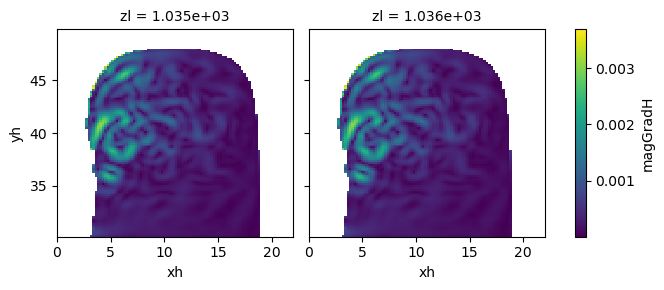

In [7]:
dtree['DG']['100'].magGradH.isel(Time=-1).plot(col='zl')

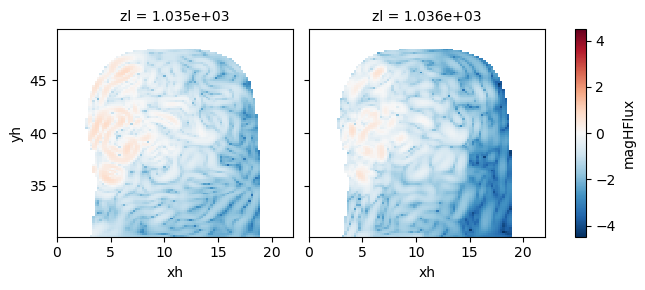

In [8]:
np.log10(dtree['DG']['100'].magHFlux).isel(Time=-1).plot(col='zl')

### Output magnitude scaling

In [8]:
def plot_box_whiskers(exp_name):
    for i, L in enumerate(L_values): 
        Lscale = float(L) #* 1e3
        C = 20
        ds = dtree[exp_name][L]
        ds = ds.where(ds.hbar.isel(zl=1)>1.)
    
        data = []
        data_norm = []
    
        for zl in z_levels:
            magHFlux = ds.magHFlux.isel(zl=zl).values.reshape(-1)
            
    
            magGradU = ds.magGradU.isel(zl=zl).values.reshape(-1)
            
            magGradU = magGradU[~np.isnan(magHFlux)]
            magHFlux = magHFlux[~np.isnan(magHFlux)]
            
            
            data.append(np.log10(magHFlux))
            data_norm.append(np.log10(magHFlux / magGradU / Lscale**2/ C))
    
        # Plot original data
        for j, (d, color) in enumerate(zip(data, colors)):
            box1 = plt.boxplot(d, 
                               positions=[i * 4 + j * 0.25],  # Increase the spacing
                               patch_artist=True,  # Allows box to be filled
                               boxprops=dict(linewidth=1.5, color=color), 
                               medianprops=dict(linewidth=1.5, color='tab:red'),
                               whiskerprops=dict(linewidth=1.5, linestyle='--'),
                               capprops=dict(linewidth=1.5),
                               showfliers=False, 
                               widths=0.2)  # Make the box plots wider
    
            for patch in box1['boxes']:
                patch.set_facecolor('lightgrey')  # White for regular data
    
        # Plot normalized data with distinct style
        for j, (d_norm, color) in enumerate(zip(data_norm, colors)):
            box2 = plt.boxplot(d_norm, 
                               positions=[i * 4 + 1 + j * 0.25],  # Separate positions for normalized data
                               patch_artist=True,  # Allows box to be filled
                               boxprops=dict(linewidth=1.5, color=color), 
                               medianprops=dict(linewidth=1.5, color='tab:red'),
                               whiskerprops=dict(linewidth=1.5, linestyle=':'),
                               capprops=dict(linewidth=1.5),
                               showfliers=False, 
                               widths=0.2)  # Make the box plots wider
    
            for patch in box2['boxes']:
                patch.set_facecolor('gray')  # Light grey for normalized data
    
    # Creating custom legend
    legend_patches = [
        mpatches.Patch(color='lightgrey', label='Regular Data', edgecolor='black'),
        mpatches.Patch(color='gray', label='Normalized Data', edgecolor='black'),
        mpatches.Patch(color='tab:blue', label='Layer 1', edgecolor='blue'),
        mpatches.Patch(color='tab:green', label='Layer 2', edgecolor='green')
    ]
    
    plt.legend(handles=legend_patches, loc='best')
    
    # Adjust xticks for visual separation
    plt.xticks([i * 4 + 0.7 for i in range(len(L_values))], L_values, fontsize=14)
    plt.yticks(fontsize=14)
    #plt.xlabel('L (km)', fontsize=14)
    plt.ylabel('log10 values', fontsize=14)
    #plt.title(r'Boxplots of Thickness Flux ($|\mathbf{F}|$) and Normalized Thickness Flux ($\frac{|\mathbf{F}|}{C \, L^2 |\nabla \mathbf{u}|}$)', fontsize=16)
    if exp_name == 'DG':
        plt.title(r'Double Gyre', fontsize=16)
    else:
        plt.title(r'Phillips 2 Layer', fontsize=16)
    
    
    #plt.grid(True)
    plt.grid(axis='y')
    plt.ylim(-5, 2.2)

In [9]:
def plot_violin(exp_name, norm_choice='with_Hgrad'):
    for i, L in enumerate(L_values): 
        Lscale = float(L) 
        #C = 40000
        ds = dtree[exp_name][L]
        ds = ds.where(ds.hbar.isel(zl=1)>1.)
    
        data = []
        data_flux_sum = []
        data_norm = []
    
        for zl in z_levels:
            magHFlux = ds.magHFlux.isel(zl=zl).values.reshape(-1)
            magGradU = ds.magGradU.isel(zl=zl).values.reshape(-1)
            magGradH = ds.magGradH.isel(zl=zl).values.reshape(-1) 

            magGradU = magGradU[~np.isnan(magHFlux)]
            magGradH = magGradH[~np.isnan(magHFlux)]
            magHFlux = magHFlux[~np.isnan(magHFlux)]

            magGradU = magGradU[~np.isinf(magHFlux)]
            magGradH = magGradH[~np.isinf(magHFlux)]
            magHFlux = magHFlux[~np.isinf(magHFlux)]
            
            data.append(np.log10(magHFlux))
            if norm_choice == 'with_Hgrad':
                C = 4e4
                data_norm.append(np.log10(magHFlux / magGradU / magGradH / Lscale**2 /C))
            elif norm_choice == 'without_Hgrad':
                C = 20
                data_norm.append(np.log10(magHFlux / magGradU / Lscale**2 /C))
        
        magHFluxSum = ds.magHFlux_sum.values.reshape(-1)
        magHFluxSum = magHFluxSum[~np.isnan(magHFluxSum)]
        data_flux_sum.append(np.log10(magHFluxSum)) 
    
        # Set positions for each violin plot
        pos_data = [i * 4 - 0.2+ j * 0.25 for j in range(len(z_levels))]
        pos_data_flux_sum = [i * 4 + 0.4 +j * 0.25 for j in range(1)]
        pos_data_norm = [i * 4 + 1 + j * 0.25 for j in range(len(z_levels))]
    
        # Plot regular data
        parts = plt.violinplot(data, positions=pos_data, showmeans=False, 
                               showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.7)
        plt.scatter(pos_data, [np.median(d) for d in data], color='red', marker='o')

        # Plot flux sum data
        parts = plt.violinplot(data_flux_sum, positions=pos_data_flux_sum, showmeans=False, 
                               showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts['bodies'], [colors[2]]):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.7)
        plt.scatter(pos_data_flux_sum, [np.median(d) for d in data_flux_sum], color='red', marker='o')

        # Plot normalized data
        parts_norm = plt.violinplot(data_norm, positions=pos_data_norm, showmeans=False, 
                                    showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts_norm['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.3)
        plt.scatter(pos_data_norm, [np.median(dn) for dn in data_norm], color='darkorange', marker='o')
    
    # Creating custom legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='tab:blue', label='Layer 1'),
        mpatches.Patch(color='tab:green', label='Layer 2'),
        mpatches.Patch(color='tab:red', label='Layers sum'),
        mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Median (Regular Data)'),
        mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', label='Median (Normalized Data)'),
        mpatches.Patch(color='gray', alpha=0.7, label='Solid color: Regular Data'),
        mpatches.Patch(color='gray', alpha=0.3, label='Faint color: Normalized Data')
    ]

    
    #plt.legend(handles=legend_patches, loc='best', fontsize=12)
    
    # Adjust xticks for visual separation
    plt.xticks([i * 4 + 0.5 for i in range(len(L_values))], L_values, fontsize=14)
    #plt.xlabel('L scale (km)', fontsize=14)
    plt.ylabel(r'log_{10} |Flux| ', fontsize=14)
    #plt.title('Violin Plots of magHFlux and Normalized magHFlux with Distinct Styles', fontsize=16)
    if exp_name == 'DG':
        plt.title(r'Double Gyre', fontsize=16)
    else:
        plt.legend(handles=legend_patches, loc='best', fontsize=12)
        plt.title(r'Phillips 2 Layer', fontsize=16)
    plt.grid(axis='y')

    plt.ylim(-5, 2.2)
    

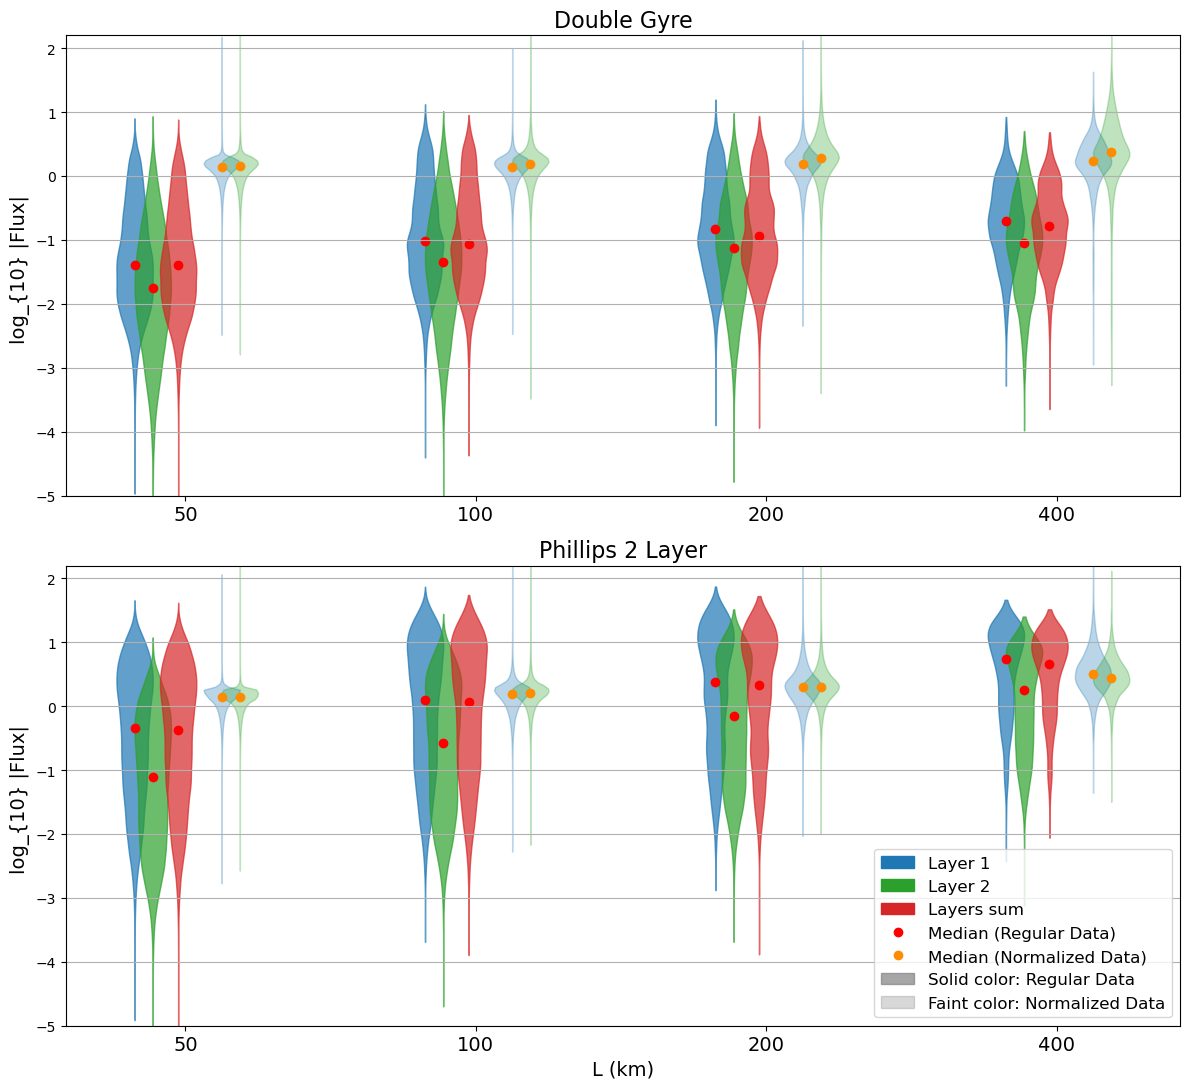

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


L_values = ['50', '100', '200', '400']
z_levels = [0, 1]
colors = ['tab:blue', 'tab:green', 'tab:red']  # Colors for different zl values

plt.figure(figsize=(12, 11))
plt.subplot(211)
plot_violin(exp_name='DG')

plt.subplot(212)
plot_violin(exp_name='P2L')
plt.xlabel('L (km)', fontsize=14)

plt.tight_layout()
#plt.show()

#plt.savefig('Figures/Figure2.png')


### Compare normalizations with our withouts grad H

In [19]:
def plot_violin_compare_norm(exp_name, e_hgrad=1e-18, e_ugrad=1e-18):
    for i, L in enumerate(L_values): 
        Lscale = float(L) 
        #C = 40000
        ds = dtree[exp_name][L]
        ds = ds.where(ds.hbar.isel(zl=1)>1.)
    
        data = []
        #data_flux_sum = []
        data_norm1 = []
        data_norm2 = []
    
        for zl in z_levels:
            magHFlux = ds.magHFlux.isel(zl=zl).values.reshape(-1) 
            magGradU = ds.magGradU.isel(zl=zl).values.reshape(-1) + e_ugrad
            magGradH = ds.magGradH.isel(zl=zl).values.reshape(-1) + e_hgrad

            magGradU = magGradU[~np.isnan(magHFlux)]
            magGradH = magGradH[~np.isnan(magHFlux)]
            magHFlux = magHFlux[~np.isnan(magHFlux)]

            magGradU = magGradU[~np.isinf(magHFlux)]
            magGradH = magGradH[~np.isinf(magHFlux)]
            magHFlux = magHFlux[~np.isinf(magHFlux)]
            
            data.append(np.log10(magHFlux))
            #if norm_choice == 'with_Hgrad':
            C1 = 4e4
            data_norm1.append(np.log10(magHFlux / magGradU / magGradH / Lscale**2 /C1))
            #elif norm_choice == 'without_Hgrad':
            C2 = 20
            data_norm2.append(np.log10(magHFlux / magGradU / Lscale**2 /C2))
        
        # magHFluxSum = ds.magHFlux_sum.values.reshape(-1)
        # magHFluxSum = magHFluxSum[~np.isnan(magHFluxSum)]
        # data_flux_sum.append(np.log10(magHFluxSum)) 
    
        # Set positions for each violin plot
        pos_data = [i * 4 - 1 + j * 0.25 for j in range(len(z_levels))]
        # pos_data_flux_sum = [i * 4 + 0.4 +j * 0.25 for j in range(1)]
        pos_data_norm1 = [i * 4  + j * 0.25 for j in range(len(z_levels))]
        pos_data_norm2 = [i * 4 + 1 + j * 0.25 for j in range(len(z_levels))]
    
        # Plot regular data
        parts = plt.violinplot(data, positions=pos_data, showmeans=False, 
                               showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.9)
        plt.scatter(pos_data, [np.median(d) for d in data], color='red', marker='o')

        # Plot flux sum data
        # parts = plt.violinplot(data_flux_sum, positions=pos_data_flux_sum, showmeans=False, 
        #                        showmedians=False, showextrema=False, widths=0.5)
        # for pc, color in zip(parts['bodies'], [colors[2]]):
        #     pc.set_facecolor(color)
        #     pc.set_edgecolor(color)
        #     pc.set_alpha(0.7)
        # plt.scatter(pos_data_flux_sum, [np.median(d) for d in data_flux_sum], color='red', marker='o')

        # Plot normalized data
        parts_norm1 = plt.violinplot(data_norm1, positions=pos_data_norm1, showmeans=False, 
                                    showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts_norm1['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.7)
        plt.scatter(pos_data_norm1, [np.median(dn) for dn in data_norm1], color='darkorange', marker='o')

        # Plot normalized data 2
        parts_norm2 = plt.violinplot(data_norm2, positions=pos_data_norm2, showmeans=False, 
                                    showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts_norm2['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.3)
        plt.scatter(pos_data_norm2, [np.median(dn) for dn in data_norm2], color='darkorange', marker='o')


    
    # Creating custom legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='tab:blue', label='Layer 1'),
        mpatches.Patch(color='tab:green', label='Layer 2'),
        #mpatches.Patch(color='tab:red', label='Layers sum'),
        mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Median (Regular Data)'),
        mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', label='Median (Normalized Data)'),
        mpatches.Patch(color='gray', alpha=0.9, label=r'Solid color: Regular Data'),
        mpatches.Patch(color='gray', alpha=0.7, label=r'Faint color: Normalized Data $|F|/ (|\nabla U| |\nabla H| L^2)$'),
        mpatches.Patch(color='gray', alpha=0.3, label=r'Faintest color: Normalized Data $|F|/(|\nabla U|  L^2)$')
    ]

    
    #plt.legend(handles=legend_patches, loc='best', fontsize=12)
    
    # Adjust xticks for visual separation
    plt.xticks([i * 4 + 0.5 for i in range(len(L_values))], L_values, fontsize=14)
    #plt.xlabel('L scale (km)', fontsize=14)
    plt.ylabel(r'$\log_{10} |F|$', fontsize=14)
    #plt.title('Violin Plots of magHFlux and Normalized magHFlux with Distinct Styles', fontsize=16)
    if exp_name == 'DG':
        plt.title(r'Double Gyre', fontsize=16)
    else:
        plt.legend(handles=legend_patches, loc='best', fontsize=12)
        plt.title(r'Phillips 2 Layer', fontsize=16)
    plt.grid(axis='y')

    plt.ylim(-5, 4.2)
    

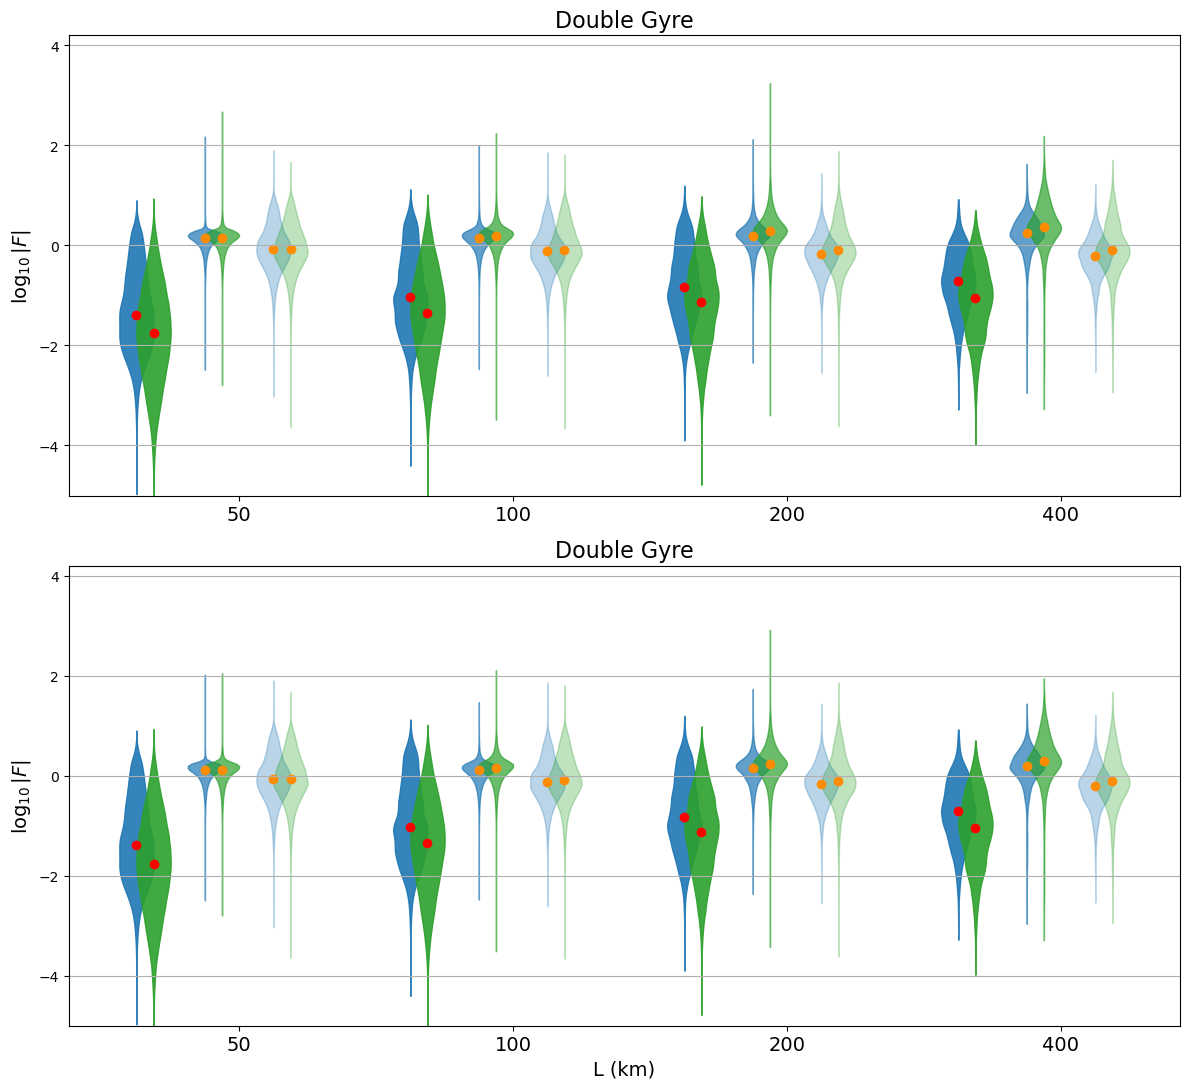

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


L_values = ['50', '100', '200', '400']
z_levels = [0, 1]
colors = ['tab:blue', 'tab:green', 'tab:red']  # Colors for different zl values

plt.figure(figsize=(12, 11))
plt.subplot(211)
plot_violin_compare_norm(exp_name='DG')

plt.subplot(212)
plot_violin_compare_norm(exp_name='DG', e_hgrad=2e-5, e_ugrad=1e-9)
plt.xlabel('L (km)', fontsize=14)

plt.tight_layout()
#plt.show()

#plt.savefig('Figures/Figure_compare_norm.png')


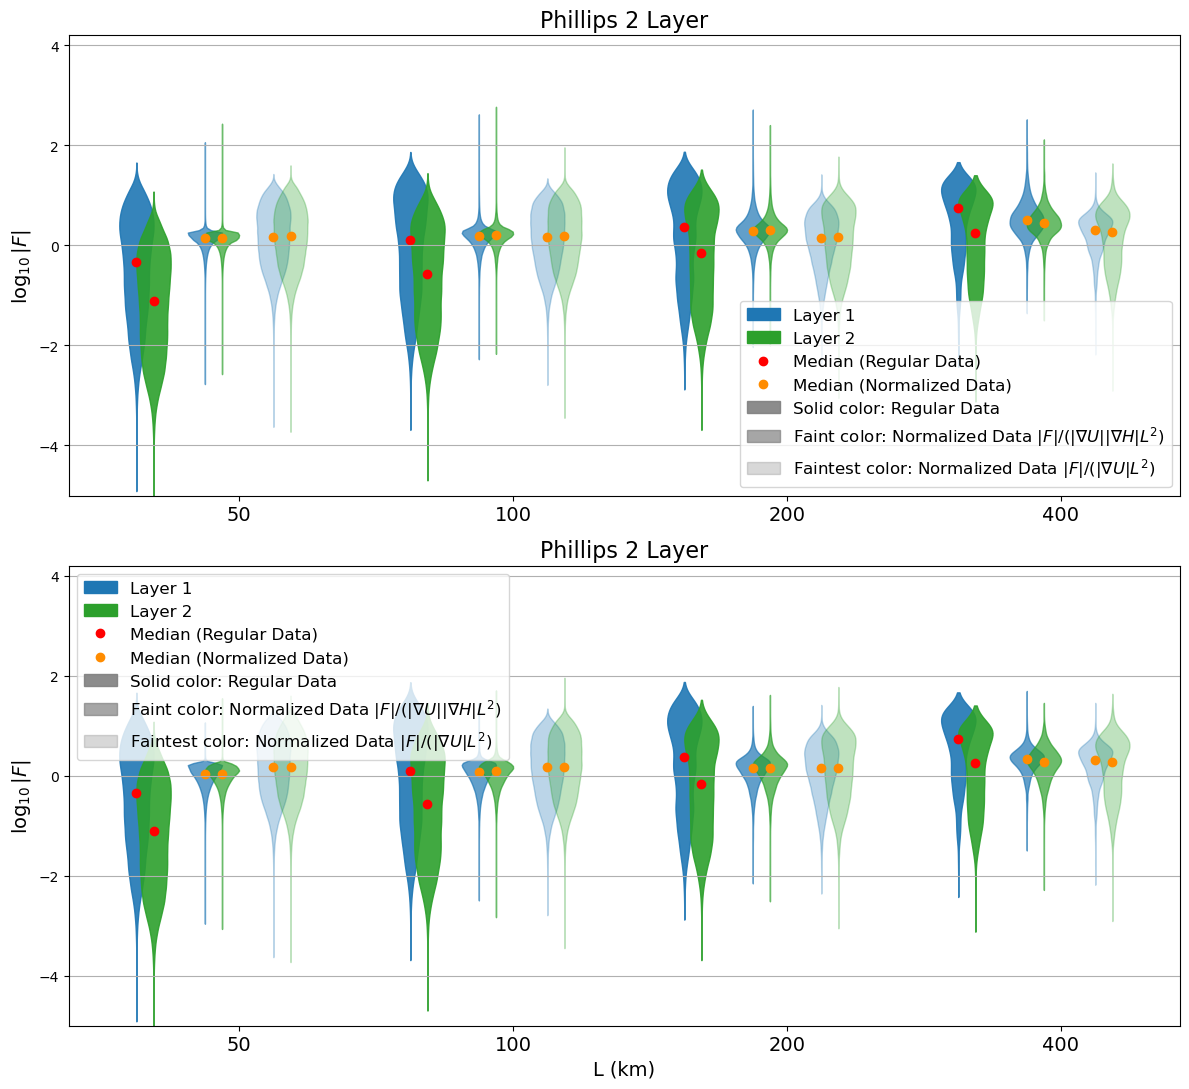

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


L_values = ['50', '100', '200', '400']
z_levels = [0, 1]
colors = ['tab:blue', 'tab:green', 'tab:red']  # Colors for different zl values

plt.figure(figsize=(12, 11))
plt.subplot(211)
plot_violin_compare_norm(exp_name='P2L')

plt.subplot(212)
plot_violin_compare_norm(exp_name='P2L', e_hgrad=1e-4, e_ugrad=1e-9)
plt.xlabel('L (km)', fontsize=14)

plt.tight_layout()
#plt.show()

#plt.savefig('Figures/Figure_compare_norm.png')


## Compare normalizations with and without widened gradients. 

In [20]:
def plot_violin_wider_norms(exp_name):
    for i, L in enumerate(L_values): 
        Lscale = float(L) 
        #C = 40000
        ds = dtree[exp_name][L]
        ds = ds.where(ds.hbar.isel(zl=1)>1.)
    
        data = []
        #data_flux_sum = []
        data_norm1 = []
        data_norm2 = []
    
        for zl in z_levels:
            magHFlux = ds.magHFlux.isel(zl=zl).values.reshape(-1)
            magGradU = ds.magGradU.isel(zl=zl).values.reshape(-1)
            magGradH = ds.magGradH.isel(zl=zl).values.reshape(-1) 
            magGradU_wide = ds.mag_nabla_u_widened.isel(zl=zl).values.reshape(-1)
            magGradH_wide = ds.mag_nabla_h_widened.isel(zl=zl).values.reshape(-1) 

            magGradU = magGradU[~np.isnan(magHFlux)]
            magGradH = magGradH[~np.isnan(magHFlux)]
            magGradU_wide = magGradU_wide[~np.isnan(magHFlux)]
            magGradH_wide = magGradH_wide[~np.isnan(magHFlux)]
            
            magHFlux = magHFlux[~np.isnan(magHFlux)]

            #magGradU = magGradU[~np.isinf(magHFlux)]
            #magGradH = magGradH[~np.isinf(magHFlux)]
            #magHFlux = magHFlux[~np.isinf(magHFlux)]
            
            data.append(np.log10(magHFlux))
            #if norm_choice == 'with_Hgrad':
            C1 = 4e4
            data_norm1.append(np.log10(magHFlux / magGradU / magGradH / Lscale**2 /C1))
            #elif norm_choice == 'without_Hgrad':
            C2 = C1/9
            data_norm2.append(np.log10(magHFlux / magGradU_wide/ magGradH_wide / Lscale**2 /C2))
        
        # magHFluxSum = ds.magHFlux_sum.values.reshape(-1)
        # magHFluxSum = magHFluxSum[~np.isnan(magHFluxSum)]
        # data_flux_sum.append(np.log10(magHFluxSum)) 
    
        # Set positions for each violin plot
        pos_data = [i * 4 - 1 + j * 0.25 for j in range(len(z_levels))]
        # pos_data_flux_sum = [i * 4 + 0.4 +j * 0.25 for j in range(1)]
        pos_data_norm1 = [i * 4  + j * 0.25 for j in range(len(z_levels))]
        pos_data_norm2 = [i * 4 + 1 + j * 0.25 for j in range(len(z_levels))]
    
        # Plot regular data
        parts = plt.violinplot(data, positions=pos_data, showmeans=False, 
                               showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.9)
        plt.scatter(pos_data, [np.median(d) for d in data], color='red', marker='o')

        # Plot flux sum data
        # parts = plt.violinplot(data_flux_sum, positions=pos_data_flux_sum, showmeans=False, 
        #                        showmedians=False, showextrema=False, widths=0.5)
        # for pc, color in zip(parts['bodies'], [colors[2]]):
        #     pc.set_facecolor(color)
        #     pc.set_edgecolor(color)
        #     pc.set_alpha(0.7)
        # plt.scatter(pos_data_flux_sum, [np.median(d) for d in data_flux_sum], color='red', marker='o')

        # Plot normalized data
        parts_norm1 = plt.violinplot(data_norm1, positions=pos_data_norm1, showmeans=False, 
                                    showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts_norm1['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.7)
        plt.scatter(pos_data_norm1, [np.median(dn) for dn in data_norm1], color='darkorange', marker='o')

        # Plot normalized data 2
        parts_norm2 = plt.violinplot(data_norm2, positions=pos_data_norm2, showmeans=False, 
                                    showmedians=False, showextrema=False, widths=0.5)
        for pc, color in zip(parts_norm2['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.3)
        plt.scatter(pos_data_norm2, [np.median(dn) for dn in data_norm2], color='darkorange', marker='o')


    
    # Creating custom legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='tab:blue', label='Layer 1'),
        mpatches.Patch(color='tab:green', label='Layer 2'),
        #mpatches.Patch(color='tab:red', label='Layers sum'),
        mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Median (Regular Data)'),
        mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', label='Median (Normalized Data)'),
        mpatches.Patch(color='gray', alpha=0.9, label=r'Solid color: Regular Data'),
        mpatches.Patch(color='gray', alpha=0.7, label=r'Faint color: Normalized Data, central points'),
        mpatches.Patch(color='gray', alpha=0.3, label=r'Faintest color: Normalized Data, wider stencil')
    ]

    
    #plt.legend(handles=legend_patches, loc='best', fontsize=12)
    
    # Adjust xticks for visual separation
    plt.xticks([i * 4 + 0.5 for i in range(len(L_values))], L_values, fontsize=14)
    #plt.xlabel('L scale (km)', fontsize=14)
    plt.ylabel(r'$\log_{10} |F|$', fontsize=14)
    #plt.title('Violin Plots of magHFlux and Normalized magHFlux with Distinct Styles', fontsize=16)
    if exp_name == 'DG':
        plt.title(r'Double Gyre', fontsize=16)
    else:
        plt.legend(handles=legend_patches, loc='best', fontsize=12)
        plt.title(r'Phillips 2 Layer', fontsize=16)
    plt.grid(axis='y')

    plt.ylim(-5, 2.2)
    

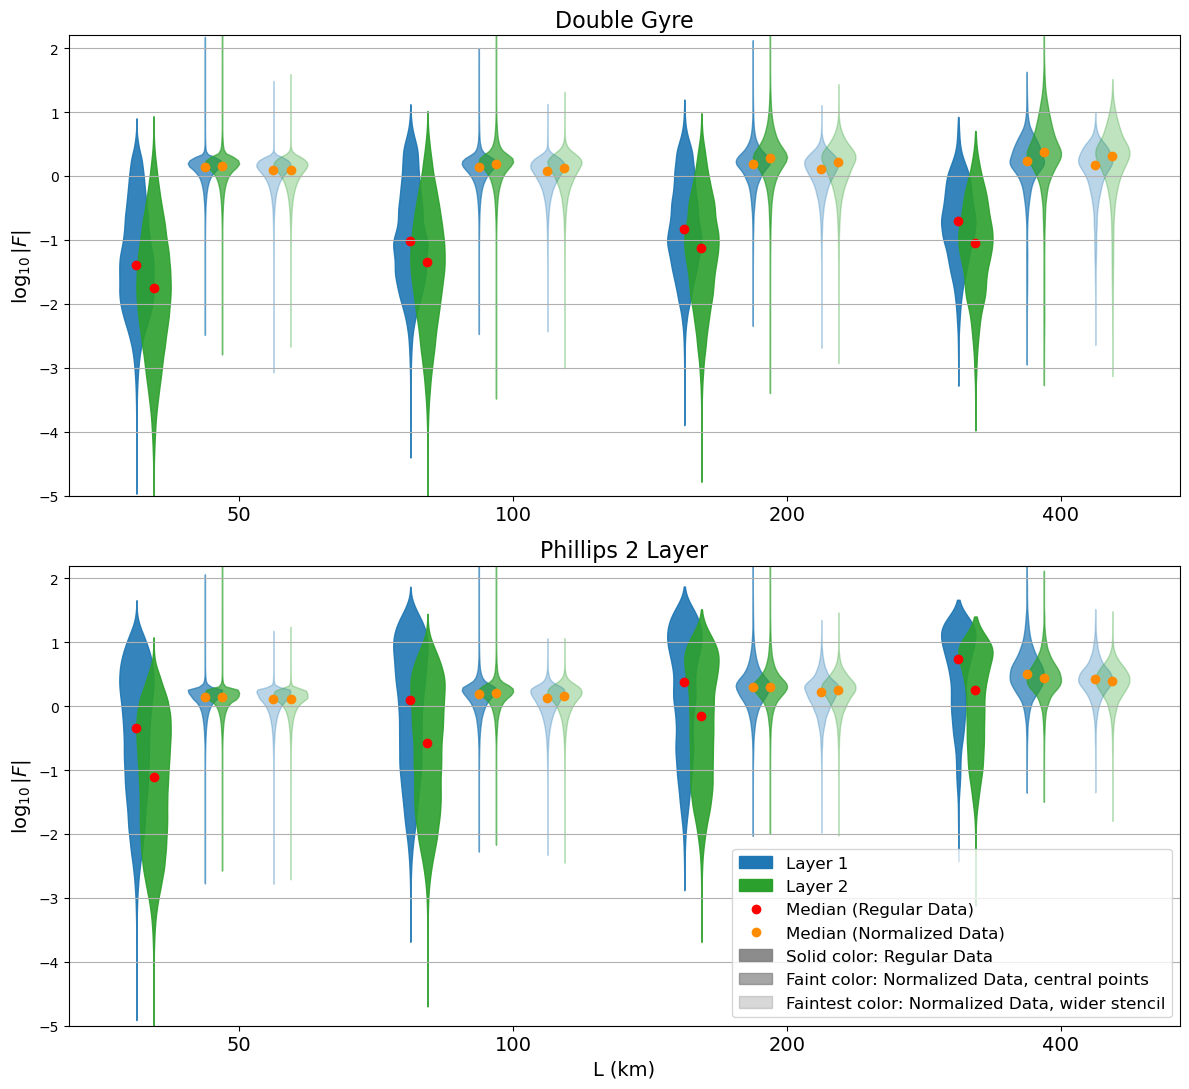

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


L_values = ['50', '100', '200', '400']
z_levels = [0, 1]
colors = ['tab:blue', 'tab:green', 'tab:red']  # Colors for different zl values

plt.figure(figsize=(12, 11))
plt.subplot(211)
plot_violin_wider_norms(exp_name='DG')

plt.subplot(212)
plot_violin_wider_norms(exp_name='P2L')
plt.xlabel('L (km)', fontsize=14)

plt.tight_layout()
#plt.show()

#plt.savefig('Figures/Figure_compare_norm.png')


## Distributions of inputs

In [18]:
def plot_violin_var_zl(var):
    for i, L in enumerate(L_values): 

        for exp in ['P2L', 'DG']: 
            ds = dtree[exp][L]
            ds = ds.where(ds.hbar.isel(zl=1)>1.)
        
            data = []
            #data_norm = []
    
            
            for zl in z_levels:
                magVar = ds[var].isel(zl=zl).values.reshape(-1)
                #magGradU = ds.magGradU.isel(zl=zl).values.reshape(-1)
    
                magVar = magVar[~np.isnan(magVar)]
                
                #magHFlux = magHFlux[~np.isnan(magHFlux)]
                
                data.append(np.log10(magVar))
                
                #data_norm.append(np.log10(magHFlux / magGradU / Lscale**2 /C))
        
            # Set positions for each violin plot
            
            #pos_data_norm = [i * 4 + 1 + j * 0.25 for j in range(len(z_levels))]
        
            # Plot regular data
            if exp == 'P2L':
                pos_data = [i * 4 + j * 0.25 for j in range(len(z_levels))]
                alpha = 0.7
            elif exp == 'DG':
                pos_data = [i * 4 + 1 + j * 0.25 for j in range(len(z_levels))]
                alpha = 0.3
                
            parts = plt.violinplot(data, positions=pos_data, showmeans=False, 
                                   showmedians=False, showextrema=False, widths=0.5)
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alpha)
            plt.scatter(pos_data, [np.median(d) for d in data], color='tab:red', marker='x')
        
            # Plot normalized data
             
                # parts_norm = plt.violinplot(data_norm, positions=pos_data_norm, showmeans=False, 
                #                             showmedians=False, showextrema=False, widths=0.5)
                # for pc, color in zip(parts_norm['bodies'], colors):
                #     pc.set_facecolor(color)
                #     pc.set_edgecolor(color)
                #     pc.set_alpha(0.3)
                # plt.scatter(pos_data_norm, [np.median(dn) for dn in data_norm], color='darkorange', marker='o')
    
    # Creating custom legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='tab:blue', label='Layer 1'),
        mpatches.Patch(color='tab:green', label='Layer 2'),
        mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Median'),
        #mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', label='Median (Normalized Data)'),
        mpatches.Patch(color='gray', alpha=0.7, label='Solid color: Phillips 2 Layer'),
        mpatches.Patch(color='gray', alpha=0.3, label='Faint color: Double Gyre')
    ]
    
    plt.legend(handles=legend_patches, loc='best', fontsize=12)
    
    # Adjust xticks for visual separation
    plt.xticks([i * 4 + 0.5 for i in range(len(L_values))], L_values, fontsize=14)
    #plt.xlabel('L scale (km)', fontsize=14)
    plt.ylabel('log10 values', fontsize=14)
    #plt.title('Violin Plots of magHFlux and Normalized magHFlux with Distinct Styles', fontsize=16)
    #if exp_name == 'DG':
    #    plt.title(r'Double Gyre', fontsize=16)
    #else:
    #    plt.title(r'Phillips 2 Layer', fontsize=16)
    if var == 'magGradU':
        plt.title(r'$|\nabla \overline{\mathbf{u}}|$')
    elif var == 'magGradH':
        plt.title(r'$|\nabla \overline{\mathbf{h}}|$')
        
    plt.grid(axis='y')

    #plt.ylim(-5, 2.2)
    

In [19]:
def plot_violin_var_zi(var):
    for i, L in enumerate(L_values): 

        for exp in ['P2L', 'DG']: 
            ds = dtree[exp][L]
            ds = ds.where(ds.hbar.isel(zl=1)>1.)
        
            data = []
            #data_norm = []
    
            
            for zl in [1]:
                magVar = ds[var].isel(zi=zl).values.reshape(-1)
                #magGradU = ds.magGradU.isel(zl=zl).values.reshape(-1)
    
                magVar = magVar[~np.isnan(magVar)]
                
                #magHFlux = magHFlux[~np.isnan(magHFlux)]
                
                data.append(np.log10(magVar))
                
                #data_norm.append(np.log10(magHFlux / magGradU / Lscale**2 /C))
        
            # Set positions for each violin plot
            
            #pos_data_norm = [i * 4 + 1 + j * 0.25 for j in range(len(z_levels))]
        
            # Plot regular data
            if exp == 'P2L':
                pos_data = [i * 4 + j * 0.25 for j in range(1)]
                alpha = 0.7
            elif exp == 'DG':
                pos_data = [i * 4 + 1 + j * 0.25 for j in range(1)]
                alpha = 0.3
                
            parts = plt.violinplot(data, positions=pos_data, showmeans=False, 
                                   showmedians=False, showextrema=False, widths=0.5)
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alpha)
            plt.scatter(pos_data, [np.median(d) for d in data], color='tab:red', marker='x')
        
            # Plot normalized data
             
                # parts_norm = plt.violinplot(data_norm, positions=pos_data_norm, showmeans=False, 
                #                             showmedians=False, showextrema=False, widths=0.5)
                # for pc, color in zip(parts_norm['bodies'], colors):
                #     pc.set_facecolor(color)
                #     pc.set_edgecolor(color)
                #     pc.set_alpha(0.3)
                # plt.scatter(pos_data_norm, [np.median(dn) for dn in data_norm], color='darkorange', marker='o')
    
    # Creating custom legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='tab:blue', label='Interface'),
        #mpatches.Patch(color='tab:green', label='Layer 2'),
        mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Median'),
        #mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', label='Median (Normalized Data)'),
        mpatches.Patch(color='gray', alpha=0.7, label='Solid color: Phillips 2 Layer'),
        mpatches.Patch(color='gray', alpha=0.3, label='Faint color: Double Gyre')
    ]
    
    plt.legend(handles=legend_patches, loc='best', fontsize=12)
    
    # Adjust xticks for visual separation
    plt.xticks([i * 4 + 0.5 for i in range(len(L_values))], L_values, fontsize=14)
    #plt.xlabel('L scale (km)', fontsize=14)
    plt.ylabel('log10 values', fontsize=14)
    #plt.title('Violin Plots of magHFlux and Normalized magHFlux with Distinct Styles', fontsize=16)
    #if exp_name == 'DG':
    #    plt.title(r'Double Gyre', fontsize=16)
    #else:
    #    plt.title(r'Phillips 2 Layer', fontsize=16)
    plt.title(r'$|\nabla \overline{\eta}|$')
    plt.grid(axis='y')

    #plt.ylim(-5, 2.2)
    

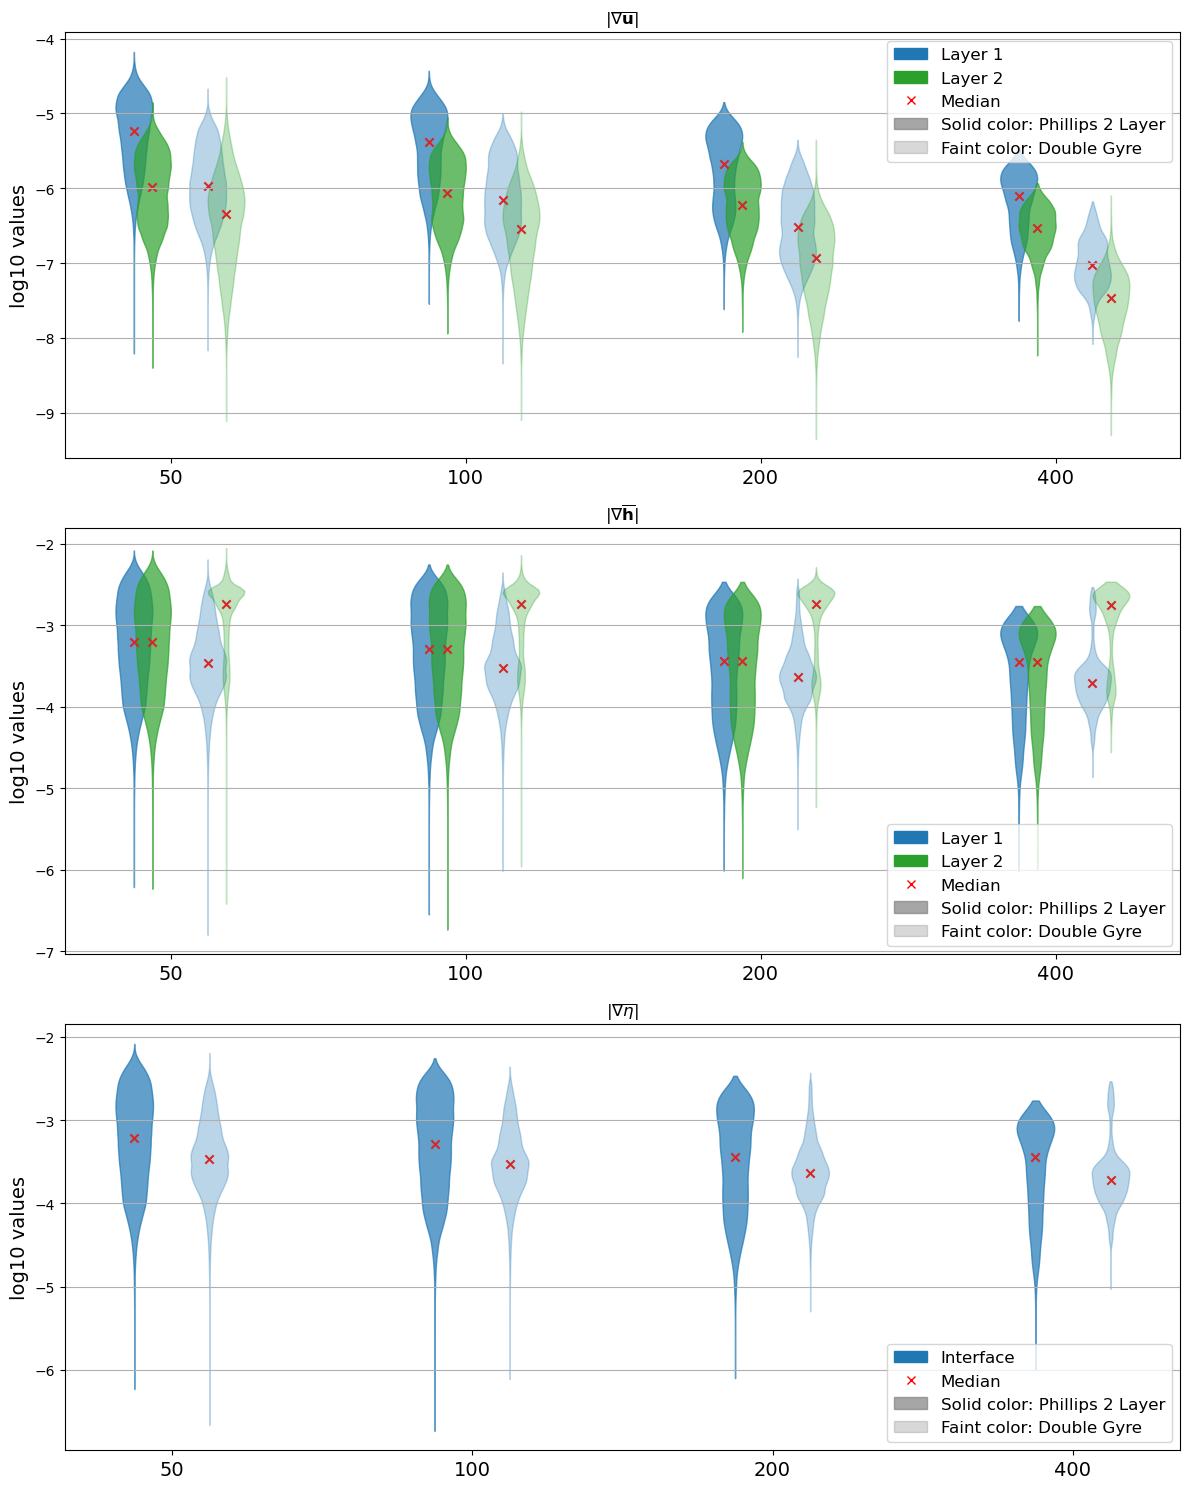

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


L_values = ['50', '100', '200', '400']
z_levels = [0, 1]
colors = ['tab:blue', 'tab:green']  # Colors for different zl values

plt.figure(figsize=(12, 15))

plt.subplot(311)
plot_violin_var_zl('magGradU')

plt.subplot(312)
plot_violin_var_zl('magGradH')

plt.subplot(313)
plot_violin_var_zi('magGradE')

plt.tight_layout()
plt.savefig('Figures/Figure2b.png')

### Orientation of fluxes relative to thickness gradients

In [68]:
import math

def angle_between_vectors(A_x, A_y, B_x, B_y):
    dot_product = A_x * B_x + A_y * B_y
    determinant = A_x * B_y - A_y * B_x
    angle = np.arctan2(determinant, dot_product)
    angle = xr.where(angle < 0, angle + 2 * np.pi, angle)
    
    return angle #if angle >= 0 else angle + 2 * math.pi

def calc_orientation(dtree): 
    for exp in ['P2L','DG']:
        for L in ['50','100','200','400']:
            ds = dtree[exp][L]

            dtree[exp][L]['ang_F_GradH'] = angle_between_vectors(ds.dhdx, ds.dhdy, ds.uphp, ds.vphp)

            dtree[exp][L]['ang_F_GradE'] = angle_between_vectors(ds.dedx.isel(zi=1), ds.dedy.isel(zi=1), ds.uphp, ds.vphp)

    return dtree

In [69]:
dtree = calc_orientation(dtree)

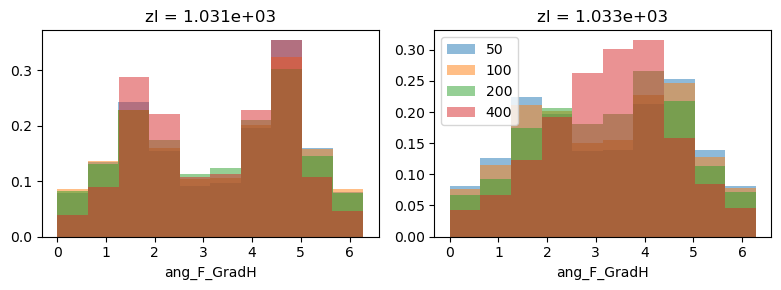

In [65]:
plt.figure(figsize=(8, 3))
for L in ['50','100','200','400']:
    ds = dtree['P2L'][L]#.sel(yh=slice(100, 1500))
    
    plt.subplot(121)
    ds.ang_F_GradH.isel(zl=0).plot.hist(alpha=0.5, label=L, density=True);

    plt.subplot(122)
    ds.ang_F_GradH.isel(zl=1).plot.hist(alpha=0.5, label=L, density=True);

plt.legend()

plt.tight_layout()

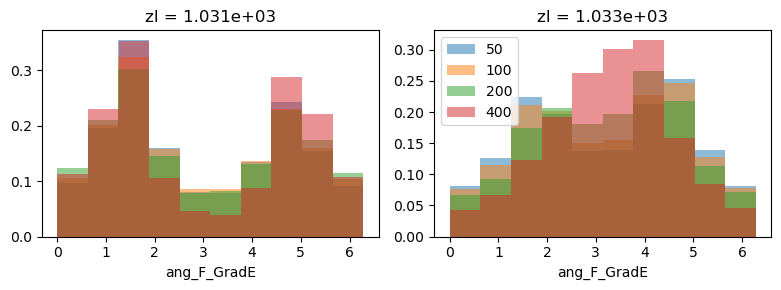

In [70]:
plt.figure(figsize=(8, 3))
for L in ['50','100','200','400']:
    ds = dtree['P2L'][L]#.sel(yh=slice(100, 1500))
    
    plt.subplot(121)
    ds.ang_F_GradE.isel(zl=0).plot.hist(alpha=0.5, label=L, density=True);

    plt.subplot(122)
    ds.ang_F_GradE.isel(zl=1).plot.hist(alpha=0.5, label=L, density=True);

plt.legend()

plt.tight_layout()

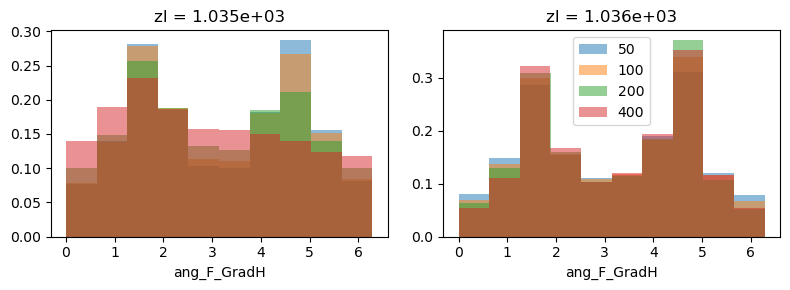

In [78]:
plt.figure(figsize=(8, 3))
for L in ['50','100','200','400']:
    ds = dtree['DG'][L]#.sel(yh=slice(100, 1500))

    ds = ds.where(ds.hbar.isel(zl=1)>1.)
    plt.subplot(121)
    ds.ang_F_GradH.isel(zl=0).plot.hist(alpha=0.5, label=L, density=True);

    plt.subplot(122)
    ds.ang_F_GradH.isel(zl=1).plot.hist(alpha=0.5, label=L, density=True);

plt.legend()

plt.tight_layout()

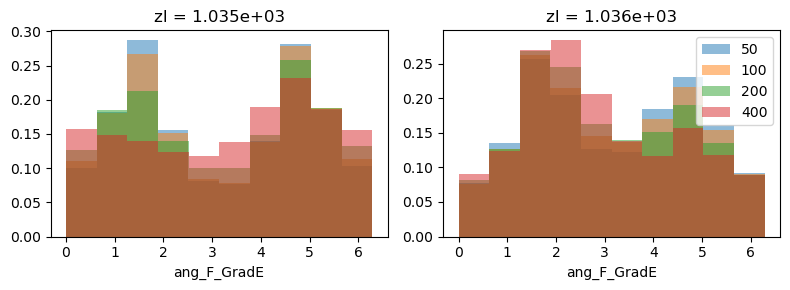

In [80]:
plt.figure(figsize=(8, 3))
for L in ['50','100','200','400']:
    ds = dtree['DG'][L]#.sel(yh=slice(100, 1500))
    ds = ds.where(ds.hbar.isel(zl=1)>1.)
    
    plt.subplot(121)
    ds.ang_F_GradE.isel(zl=0).plot.hist(alpha=0.5, label=L, density=True);

    plt.subplot(122)
    ds.ang_F_GradE.isel(zl=1).plot.hist(alpha=0.5, label=L, density=True);

plt.legend()

plt.tight_layout()

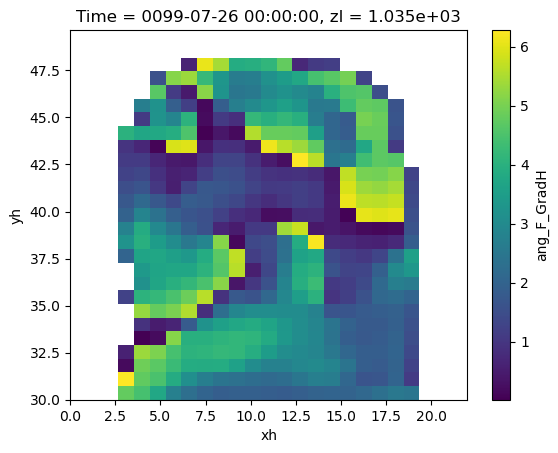

In [81]:
ds.ang_F_GradH.isel(zl=0, Time=-1).plot()

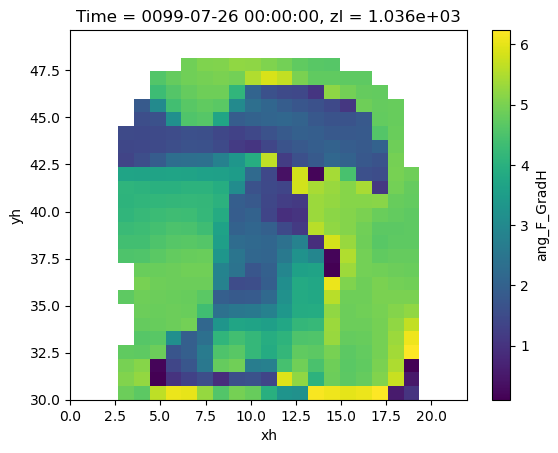

In [82]:
ds.ang_F_GradH.isel(zl=1, Time=-1).plot()

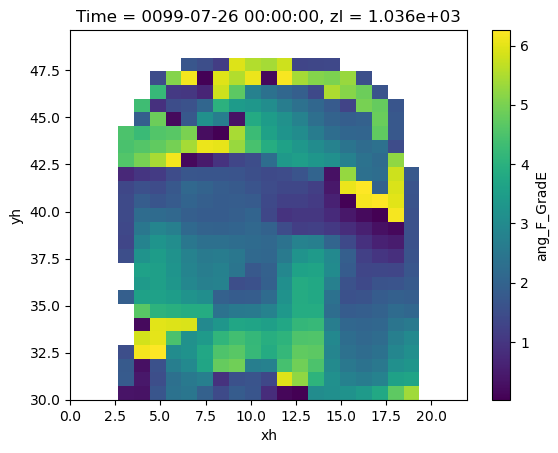

In [83]:
ds.ang_F_GradE.isel(zl=1, Time=-1).plot()

### Scraps

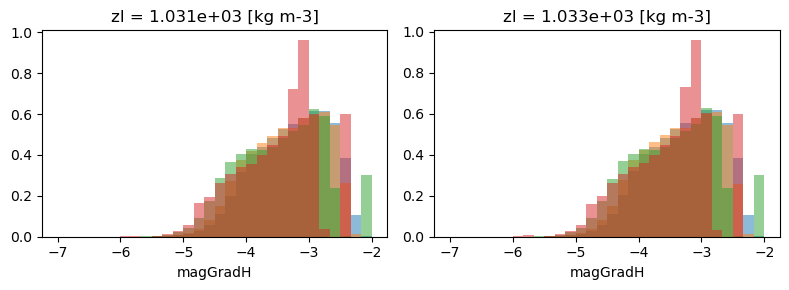

In [18]:
exp_name ='P2L'

plt.figure(figsize=(8,3))

for L in ['50','100','200','400']: 
    ds = dtree[exp_name][L]
    bins = np.linspace(-7,-2, 31)

    plt.subplot(121)
    np.log10(ds.magGradH).isel(zl=0).plot.hist(density=True, bins=bins, alpha=0.5)

    plt.subplot(122)
    np.log10(ds.magGradH).isel(zl=1).plot.hist(density=True, bins=bins, alpha=0.5)

plt.tight_layout()

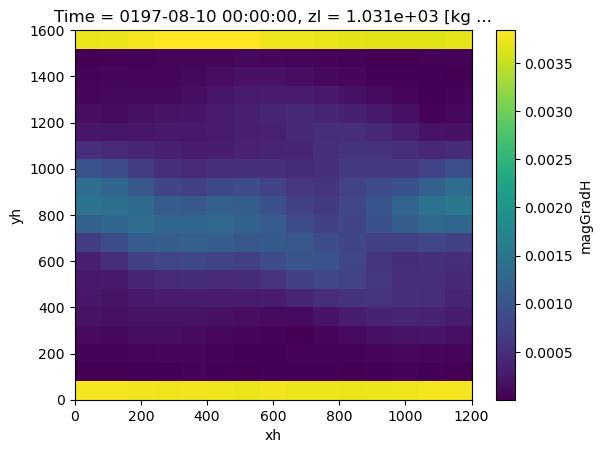

In [29]:
dtree['P2L']['400'].magGradH.isel(Time=0, zl=0).plot()

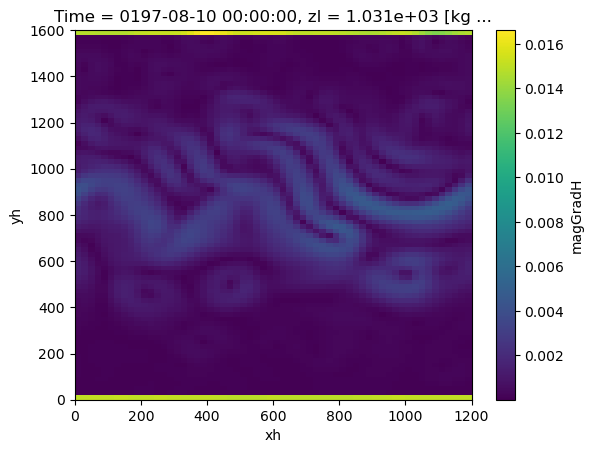

In [32]:
dtree['P2L']['100'].magGradH.isel(Time=0, zl=0).plot()

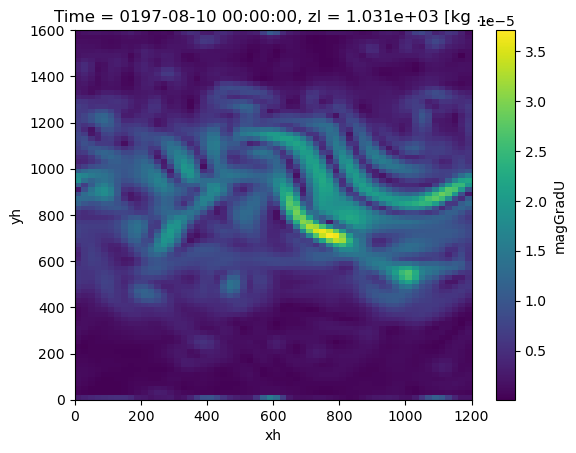

In [33]:
dtree['P2L']['100'].magGradU.isel(Time=0, zl=0).plot()

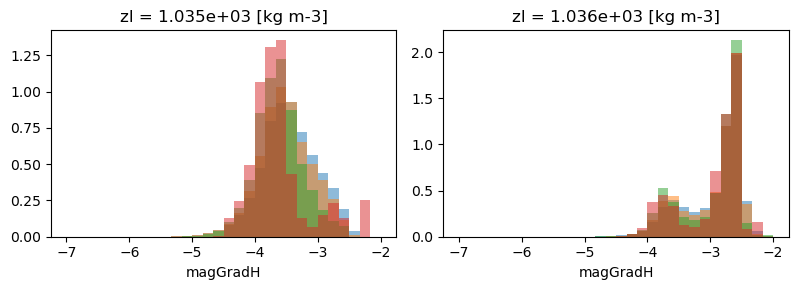

In [17]:
exp_name ='DG'

plt.figure(figsize=(8,3))

for L in ['50','100','200','400']: 
    ds = dtree[exp_name][L]
    ds = ds.where(ds.hbar.isel(zl=1)>1.)

    bins = np.linspace(-7,-2, 31)

    plt.subplot(121)
    np.log10(ds.magGradH).isel(zl=0).plot.hist(density=True, bins=bins, alpha=0.5)

    plt.subplot(122)
    np.log10(ds.magGradH).isel(zl=1).plot.hist(density=True, bins=bins, alpha=0.5)

plt.tight_layout()

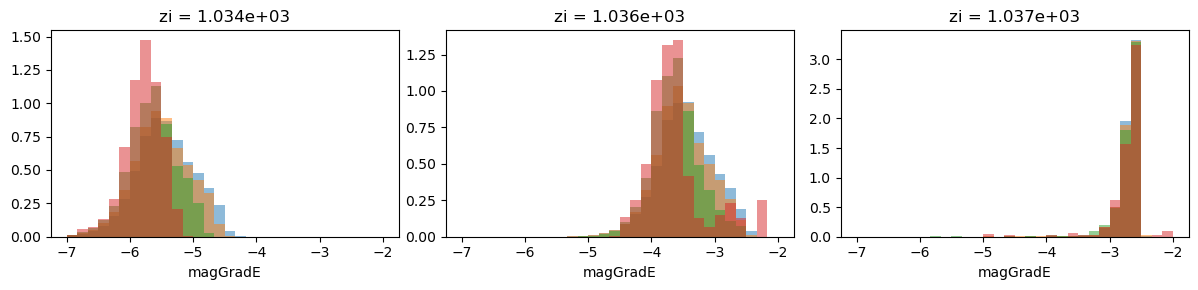

In [16]:
exp_name ='DG'

plt.figure(figsize=(12,3))

for L in ['50','100','200','400']: 
    ds = dtree[exp_name][L]
    ds = ds.where(ds.hbar.isel(zl=1)>1.)

    bins = np.linspace(-7,-2, 31)

    plt.subplot(131)
    np.log10(ds.magGradE).isel(zi=0).plot.hist(density=True, bins=bins, alpha=0.5)

    plt.subplot(132)
    np.log10(ds.magGradE).isel(zi=1).plot.hist(density=True, bins=bins, alpha=0.5)

    plt.subplot(133)
    np.log10(ds.magGradE).isel(zi=2).plot.hist(density=True, bins=bins, alpha=0.5)

plt.tight_layout()

### Flux orientations 

### Scraps below

In [92]:
def plot_hist_norm(exp,L, hmask=True): 
    ds = dtree[exp][L]
    if hmask==True:
        ds = ds.where(ds.hbar.isel(zl=1)>10.)
    Lscale = float(L)

    plt.figure(figsize=(12, 3))

    plt.subplot(131)
    bins = np.linspace(-5, 2, 41)
    np.log10(ds.magHFlux).isel(zl=0).plot.hist(density=True, bins=bins)
    np.log10(ds.magHFlux).isel(zl=1).plot.hist(density=True, bins=bins, alpha=0.5);

    plt.subplot(132)
    bins= np.linspace(-8, -4, 41)
    np.log10(ds.magGradU).isel(zl=0).plot.hist(density=True, bins=bins)
    np.log10(ds.magGradU).isel(zl=1).plot.hist(density=True, bins=bins, alpha=0.5);

    plt.subplot(133)
    bins = np.linspace(-4, 3, 41)
    np.log10(ds.magHFlux/ds.magGradU/Lscale**2).isel(zl=0).plot.hist(density=True, bins=bins)
    np.log10(ds.magHFlux/ds.magGradU/Lscale**2).isel(zl=1).plot.hist(density=True, bins=bins, alpha=0.5);

    plt.tight_layout()

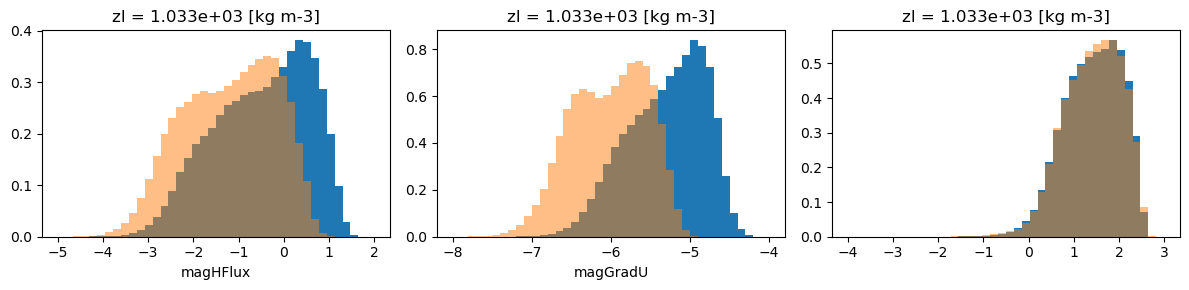

In [93]:
plot_hist_norm('P2L', '50')

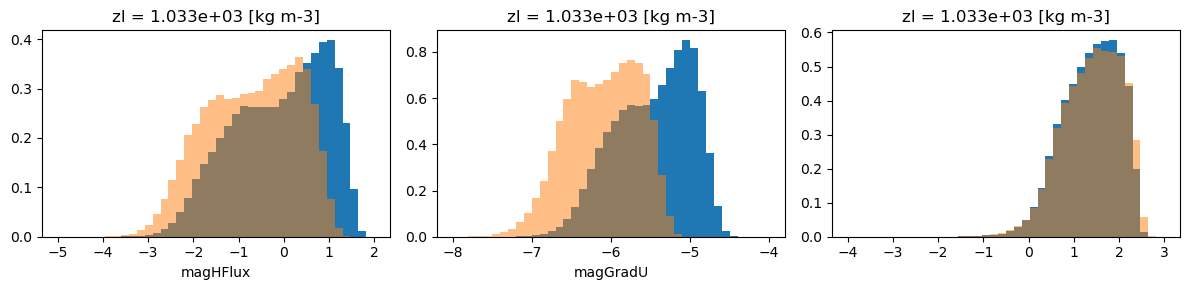

In [68]:
plot_hist_norm('P2L', '100')

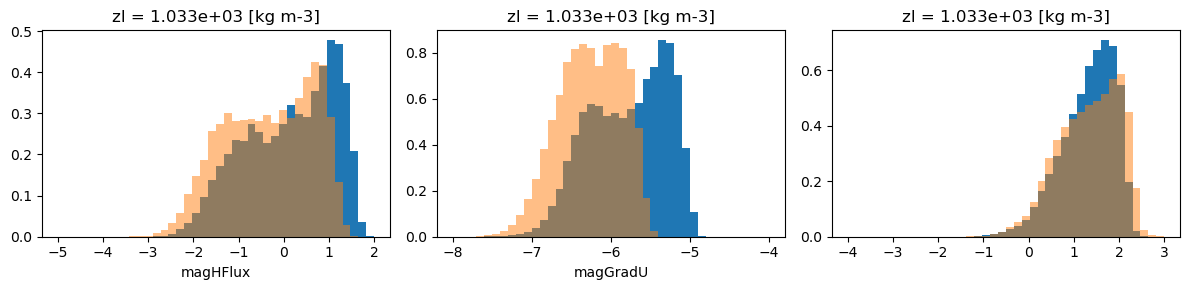

In [69]:
plot_hist_norm('P2L', '200')

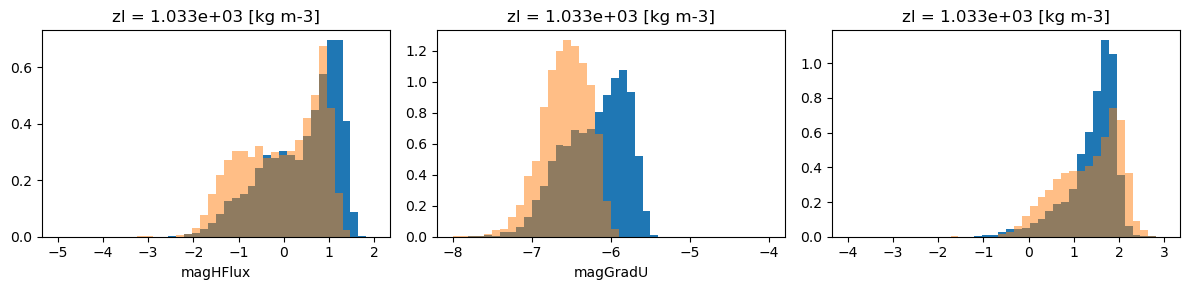

In [70]:
plot_hist_norm('P2L', '400')

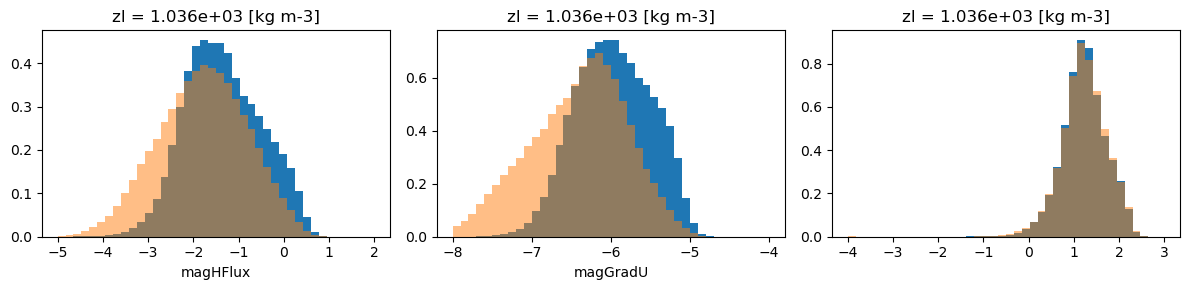

In [94]:
plot_hist_norm('DG', '50')

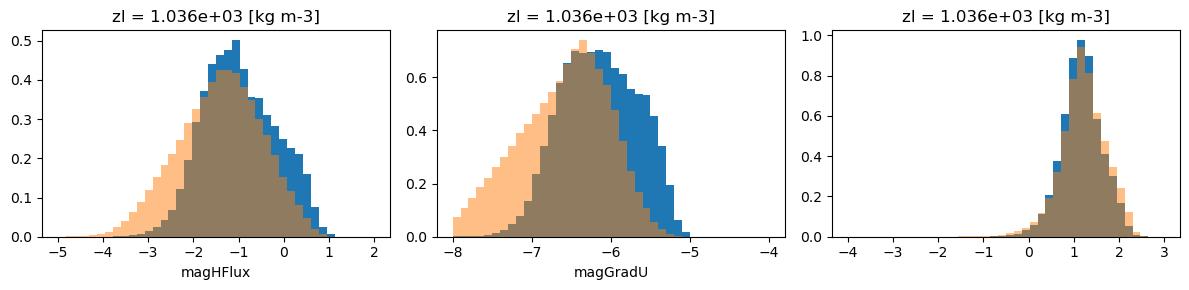

In [95]:
plot_hist_norm('DG', '100')

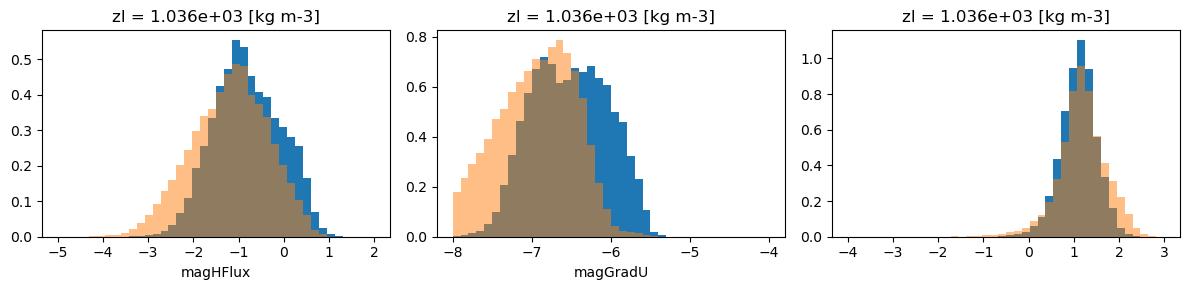

In [96]:
plot_hist_norm('DG', '200')

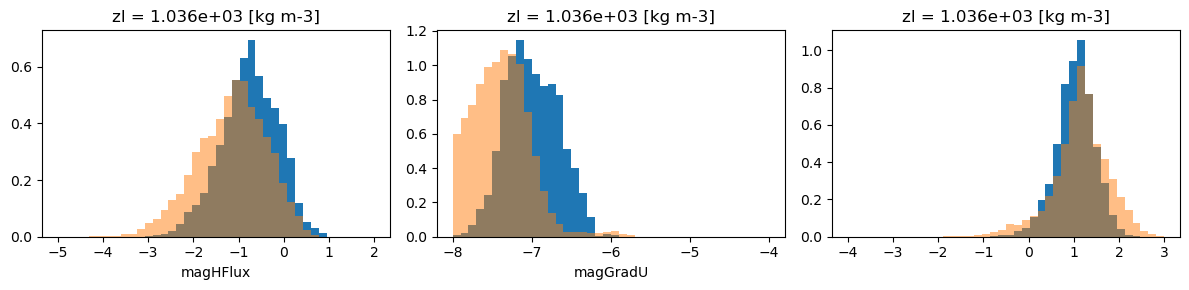

In [97]:
plot_hist_norm('DG', '400')

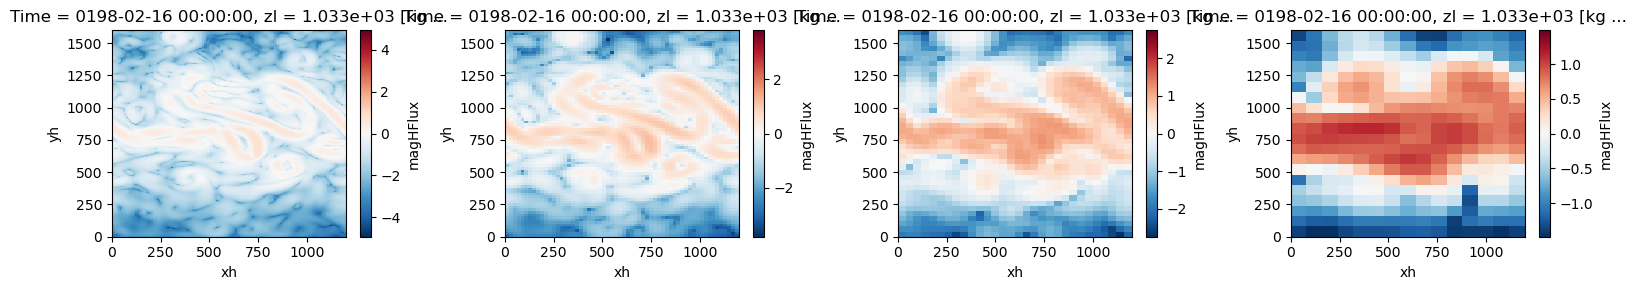

In [64]:
plt.figure(figsize=(16, 3))

for i, L in enumerate(['50','100','200','400']): 
    ds = dtree['P2L'][L]

    plt.subplot(1,4, i+1)
    np.log10(ds.magHFlux).isel(Time=-1, zl=1).plot()

plt.tight_layout()

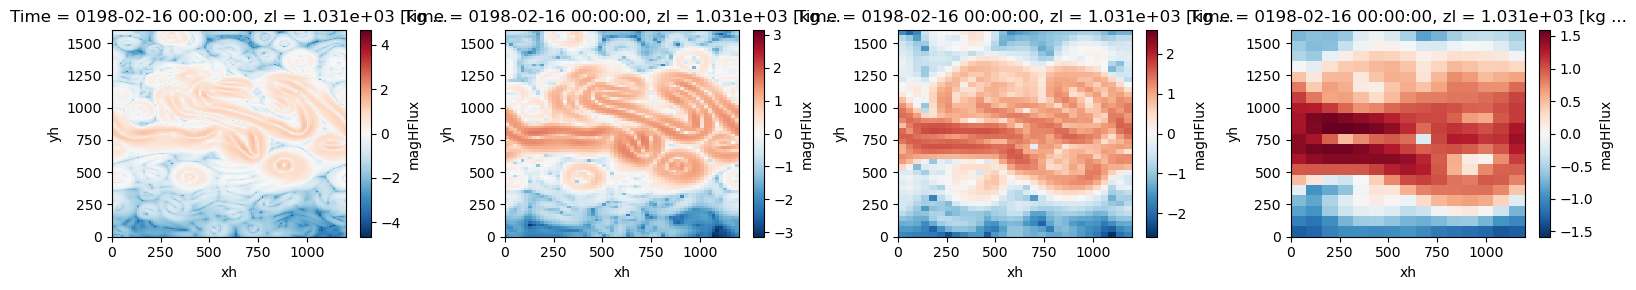

In [65]:
plt.figure(figsize=(16, 3))

for i, L in enumerate(['50','100','200','400']): 
    ds = dtree['P2L'][L]

    plt.subplot(1,4, i+1)
    np.log10(ds.magHFlux).isel(Time=-1, zl=0).plot()

plt.tight_layout()

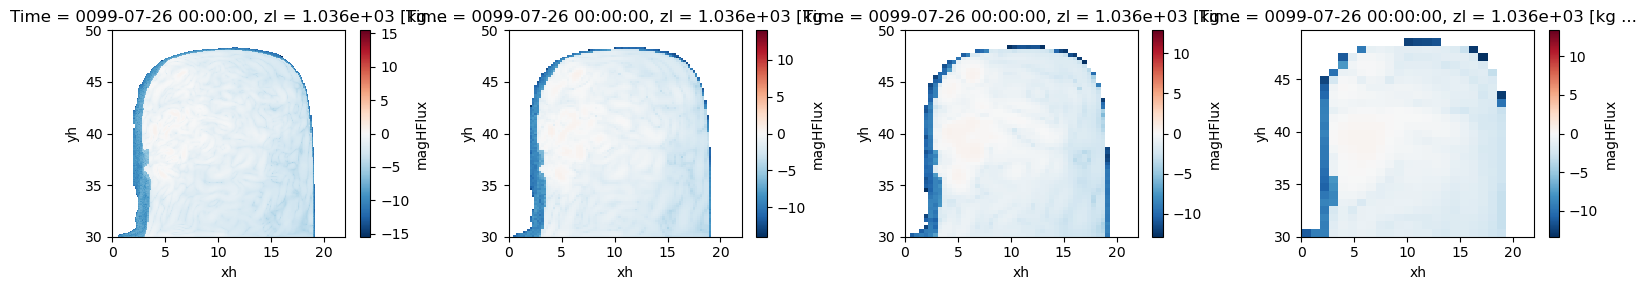

In [75]:
plt.figure(figsize=(16, 3))

for i, L in enumerate(['50','100','200','400']): 
    ds = dtree['DG'][L]

    plt.subplot(1,4, i+1)
    np.log10(ds.magHFlux).isel(Time=-1, zl=1).plot()

plt.tight_layout()

In [179]:
ds = dtree['DG']['50']

In [184]:
np.log10(ds.magHFlux.isel(zl=1)).max().values

array(0.93519396, dtype=float32)

In [185]:
np.log10(ds.magHFlux.isel(zl=1)).min().values

array(-inf, dtype=float32)

In [ ]:
np.log10(

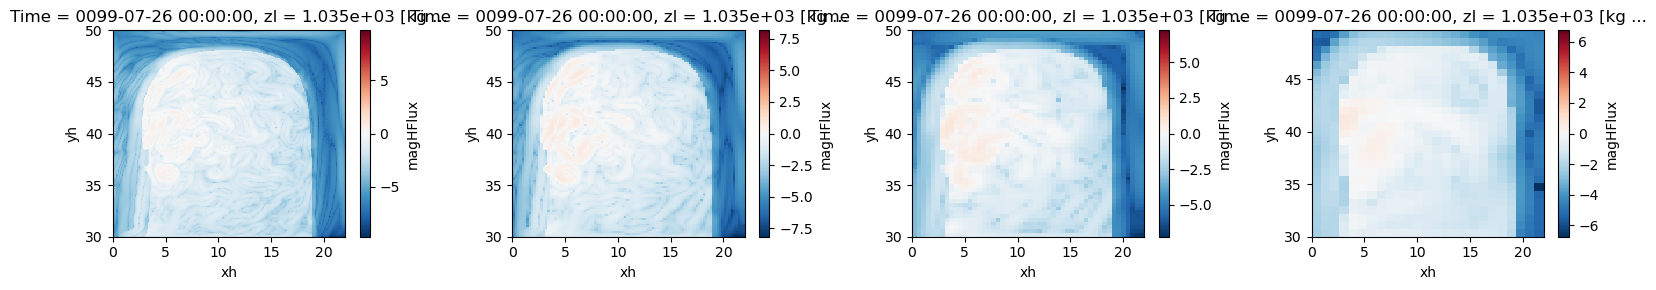

In [76]:
plt.figure(figsize=(16, 3))

for i, L in enumerate(['50','100','200','400']): 
    ds = dtree['DG'][L]

    plt.subplot(1,4, i+1)
    np.log10(ds.magHFlux).isel(Time=-1, zl=0).plot()

plt.tight_layout()

In [ ]:
def calc_mags(dataTREE):
    
    for L in ['50', '100', '200', '400']:
        ds = dataTREE.datatree[L]#.isel(time=slice(400, -1))
    
        magGradU = (ds.U_x**2 + ds.U_y**2 + ds.V_x**2 + ds.V_y**2)**0.5
        magS = (ds.Sx**2 + ds.Sy**2)**0.5

        magSfn = (ds.Sfnx**2 + ds.Sfny**2)**0.5

        PEdiss = (ds.Sfnx*ds.Sx + ds.Sfny*ds.Sy)
        Kdiss = (ds.Sfnx*ds.Sx + ds.Sfny*ds.Sy) / magS**2
        PEdiss_norm = (ds.Sfnx*ds.Sx + ds.Sfny*ds.Sy) / magS / magSfn
    
        dataTREE.datatree[L]['gradU'] = magGradU
        dataTREE.datatree[L]['magS']  = magS
        dataTREE.datatree[L]['magSfn']  = magSfn

        dataTREE.datatree[L]['PEdiss']  = PEdiss
        dataTREE.datatree[L]['Kappa']  = Kdiss
        dataTREE.datatree[L]['PEdiss_norm']  = PEdiss_norm

    return dataTREE

In [ ]:
MOM6_DG_data = calc_mags(MOM6_DG_data)
MOM6_P2L_data = calc_mags(MOM6_P2L_data)
MITgcm_data = calc_mags(MITgcm_data)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_P2L_data.datatree[L]['magS']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-5, -2])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_DG_data.datatree[L]['magS']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-5, -2])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    np.log10(MITgcm_data.datatree[L]['magS']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-5, -2])

plt.suptitle('magS')
plt.tight_layout()



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_P2L_data.datatree[L]['gradU']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-9, -4])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_DG_data.datatree[L]['gradU']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-9, -4])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    np.log10(MITgcm_data.datatree[L]['gradU']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-9, -4])


plt.suptitle('gradU')
plt.tight_layout()


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-4, 2])
plt.xlabel('')

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_DG_data.datatree[L]['magSfn']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-4, 2])
plt.xlabel('')

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    np.log10(MITgcm_data.datatree[L]['magSfn']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-4, 2])
plt.xlabel('')

plt.suptitle('log10(|$\Psi$|)')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['magS']/MOM6_P2L_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
#plt.grid()
plt.xlim([2, 8])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_DG_data.datatree[L]['magSfn']/MOM6_DG_data.datatree[L]['magS']/MOM6_DG_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([2, 8])
#plt.grid()

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MITgcm_data.datatree[L]['magSfn']/MITgcm_data.datatree[L]['magS']/MITgcm_data.datatree[L]['gradU']/Lint**2).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([2, 8])
#plt.grid()

plt.suptitle(r'log10($\frac{|\Psi|}{ |S|/ |\nabla U|/ L^2})$')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['magS']**2/MOM6_P2L_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.grid()
plt.xlim([3, 7])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_DG_data.datatree[L]['magSfn']/MOM6_DG_data.datatree[L]['magS']**2/MOM6_DG_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([3, 7])
plt.grid()

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MITgcm_data.datatree[L]['magSfn']/MITgcm_data.datatree[L]['magS']**2/MITgcm_data.datatree[L]['gradU']/Lint**2).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([3, 7])
plt.grid()

plt.suptitle('mag Sfn/ magS**0.5/ gradU/ L^2')
plt.tight_layout()

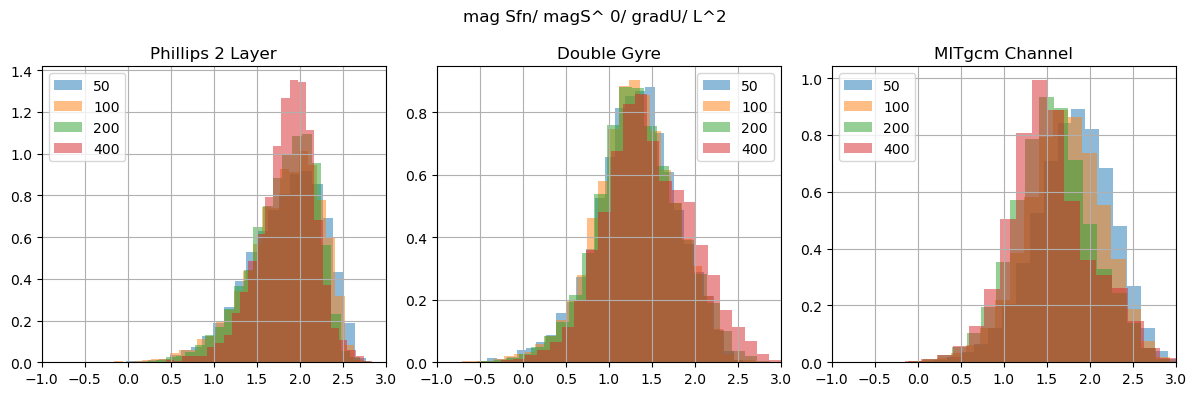

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['magS']**0/MOM6_P2L_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-1, 3])
plt.grid()

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_DG_data.datatree[L]['magSfn']/MOM6_DG_data.datatree[L]['magS']**0/MOM6_DG_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-1, 3])
plt.grid()

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MITgcm_data.datatree[L]['magSfn']/MITgcm_data.datatree[L]['magS']**0/MITgcm_data.datatree[L]['gradU']/Lint**2).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-1, 3])
plt.grid()

plt.suptitle('mag Sfn/ magS^ 0/ gradU/ L^2')
plt.tight_layout()

While the dist themselves may seem to have collapsed over each other decently, they don't collapse so well when compared to other simulations. 

Text(0.5, 1.0, 'Phillips 2 Layer')

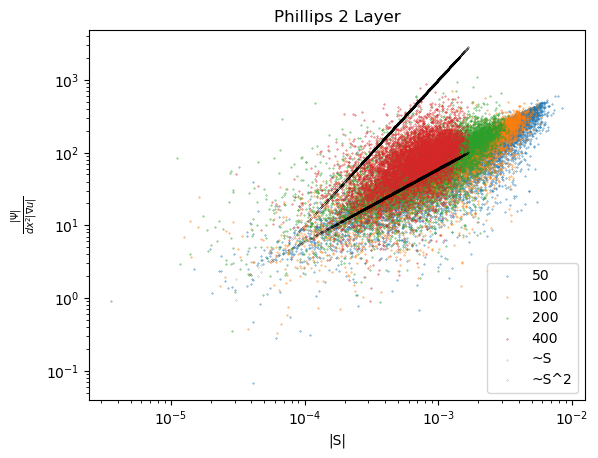

In [17]:
for L in ['50', '100', '200', '400']:
    Lint = int(L)

    y = MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['gradU']/Lint**2
    x = MOM6_P2L_data.datatree[L]['magS']
    
    plt.scatter(x, y, s=0.1, label=L)
plt.scatter(x, 0.6e5*x, s=0.01, c='k', label='~S')
plt.scatter(x, 0.1e10*(x**2), s=0.01, c='k', label='~S^2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('|S|')
plt.ylabel(r'$\frac{|\Psi|}{dx^2 |\nabla u|}$')
plt.title('Phillips 2 Layer')

Part of the reason that the above scaling goes with S is likely because at some zeroth order Taylor series does a good job at representing these eddy fluxes. 

At some level the scaling of $|Psi| ~ dx^2 |\nabla u||S|$ explains the variance quite well. However, we know that this is not the full story because the non-linear models are able to learn more than these linear models (albeit at the cost of generalizability). 

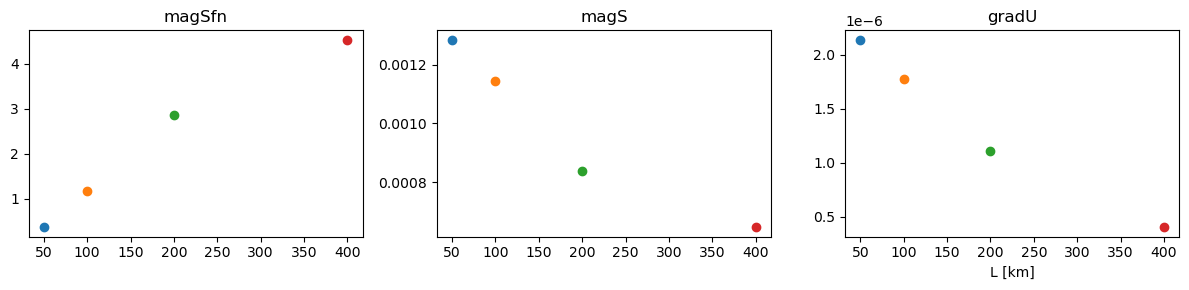

In [36]:
plt.figure(figsize=(12, 3))

for L in ['50', '100', '200', '400']:
    Lint = int(L)


    plt.subplot(131)
    y = np.log10(MOM6_P2L_data.datatree[L]['magSfn']).mean().values
    #print(y)
    plt.plot(Lint, 10**y, 'o', label='magSfn')
    
    plt.title('magSfn')


    plt.subplot(132)
    y = np.log10(MOM6_P2L_data.datatree[L]['magS']).mean()
    plt.plot(Lint, 10**y, 'o', label='magS')
    plt.title('magS')
    
    plt.subplot(133)
    y = np.log10(MOM6_P2L_data.datatree[L]['gradU']).mean()
    plt.plot(Lint, 10**y, 'o', label='gradU')
    plt.title('gradU')

#plt.scatter(x, 0.6e5*x, s=0.01, c='k', label='~S')
#plt.scatter(x, 0.1e10*(x**2), s=0.01, c='k', label='~S^2')
#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('L [km]')
#plt.ylabel(r'$\frac{|\Psi|}{dx^2 |\nabla u|}$')
#plt.title('Phillips 2 Layer')

plt.tight_layout()

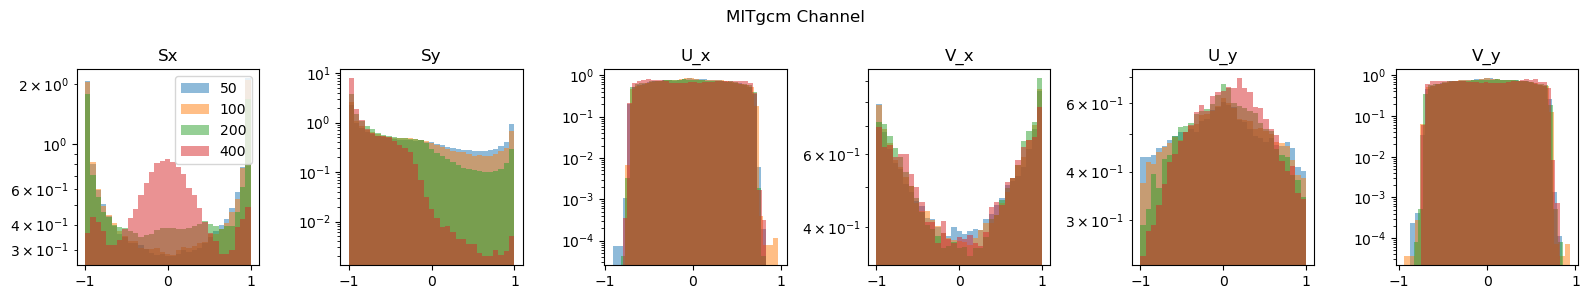

In [25]:
## inputs 

plt.figure(figsize=(16, 3))


for  L in ['50', '100', '200', '400']:
    ds = MITgcm_data.datatree[L]
    
    plt.subplot(1,6,1 )
    (ds.Sx/ds.magS).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(1,6,2 )
    (ds.Sy/ds.magS).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(1,6,3  )
    (ds.U_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(1,6,4  )
    (ds.V_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(1,6,5  )
    (ds.U_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(1,6,6  )
    (ds.V_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('MITgcm Channel')
plt.tight_layout()


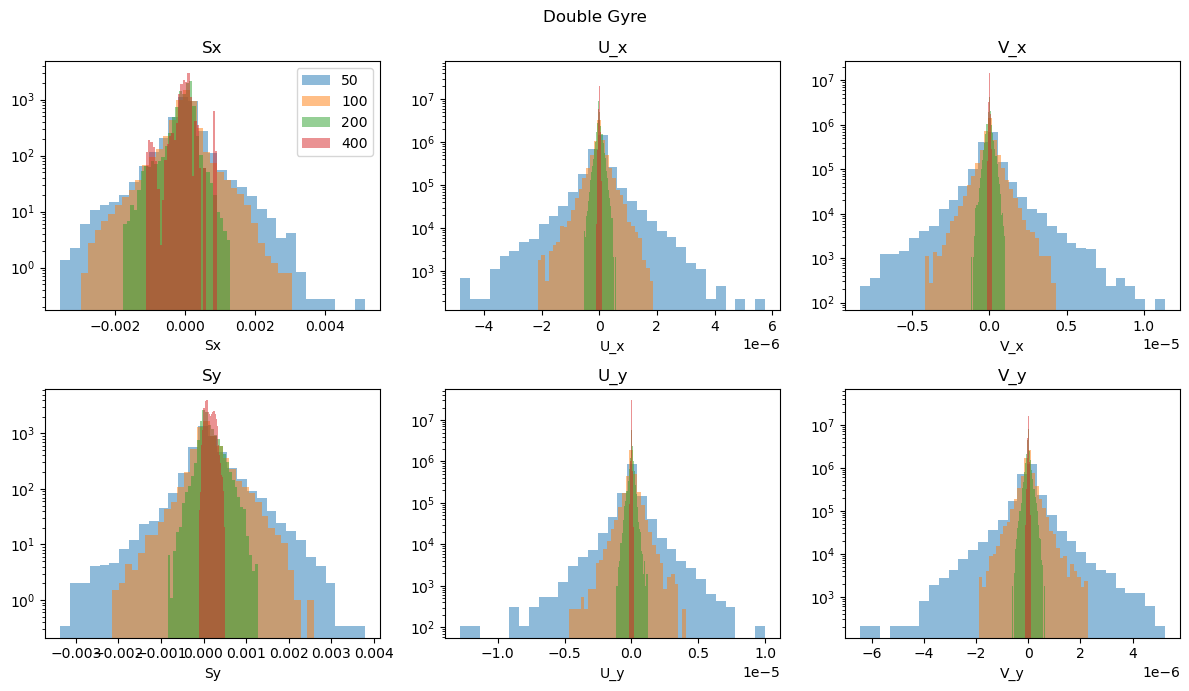

In [28]:
## inputs 

plt.figure(figsize=(12, 7))


for  L in ['50', '100', '200', '400']:
    ds = MOM6_DG_data.datatree[L]
    
    plt.subplot(2,3,1 )
    (ds.Sx).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(2,3,4 )
    (ds.Sy).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(2,3,2  )
    (ds.U_x).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(2,3,3  )
    (ds.V_x).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(2,3,5  )
    (ds.U_y).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(2,3,6  )
    (ds.V_y).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('Double Gyre')
plt.tight_layout()


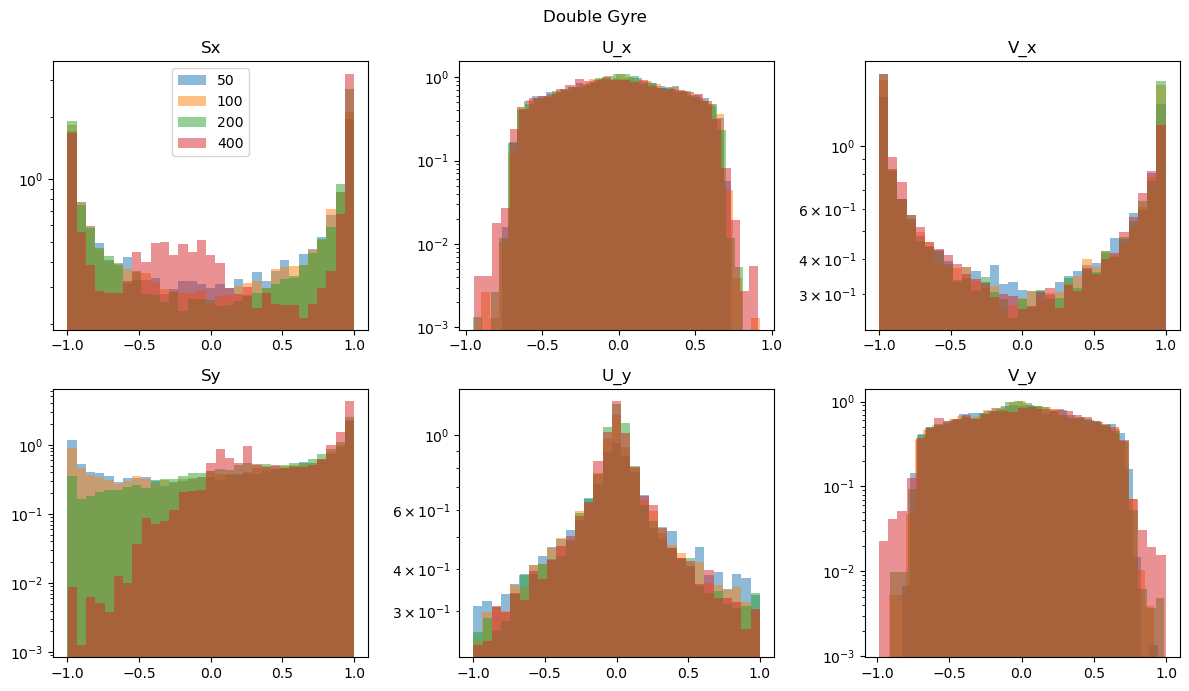

In [29]:
## inputs 

plt.figure(figsize=(12, 7))


for  L in ['50', '100', '200', '400']:
    ds = MOM6_DG_data.datatree[L]
    
    plt.subplot(2,3,1 )
    (ds.Sx/ds.magS).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(2,3,4 )
    (ds.Sy/ds.magS).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(2,3,2  )
    (ds.U_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(2,3,3  )
    (ds.V_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(2,3,5  )
    (ds.U_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(2,3,6  )
    (ds.V_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('Double Gyre')
plt.tight_layout()


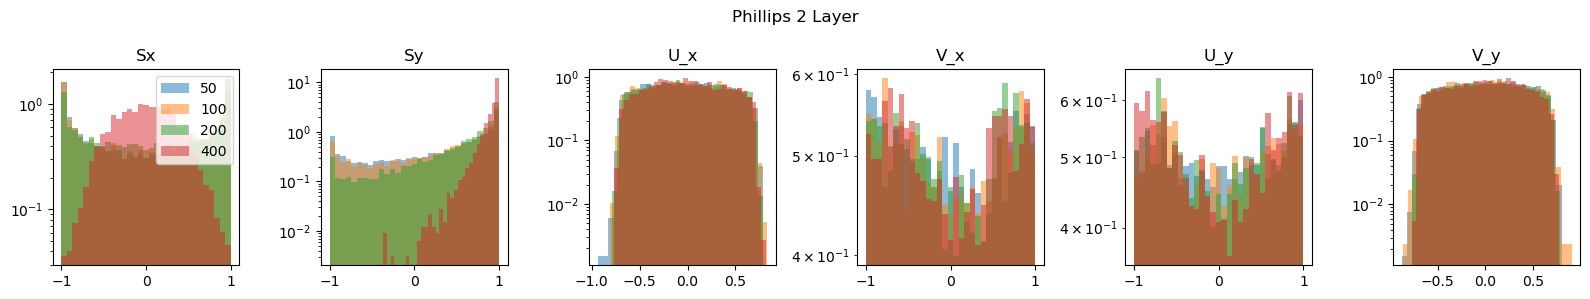

In [27]:
## inputs 

plt.figure(figsize=(16, 3))


for  L in ['50', '100', '200', '400']:
    ds = MOM6_P2L_data.datatree[L]
    
    plt.subplot(1,6,1 )
    (ds.Sx/ds.magS).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(1,6,2 )
    (ds.Sy/ds.magS).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(1,6,3  )
    (ds.U_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(1,6,4  )
    (ds.V_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(1,6,5  )
    (ds.U_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(1,6,6  )
    (ds.V_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('Phillips 2 Layer')
plt.tight_layout()


### Are fluxes dissipative

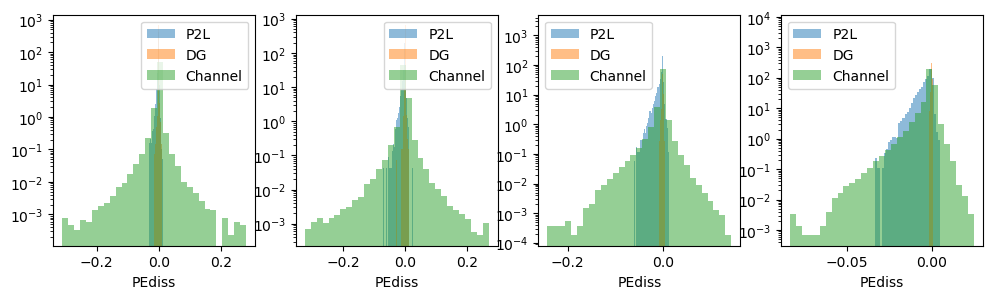

In [45]:
plt.figure(figsize=(12, 3))

for i, L in enumerate(['50', '100', '200', '400']):
    plt.subplot(1,4,1+i)
    (MOM6_P2L_data.datatree[L]['PEdiss']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='P2L', density=True)
    (MOM6_DG_data.datatree[L]['PEdiss']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='DG', density=True)
    (MITgcm_data.datatree[L]['PEdiss']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='Channel', density=True)
    plt.legend()
    plt.yscale('log')

plt.tight_layout()


Text(0.5, 0.98, 'Effective Kappa')

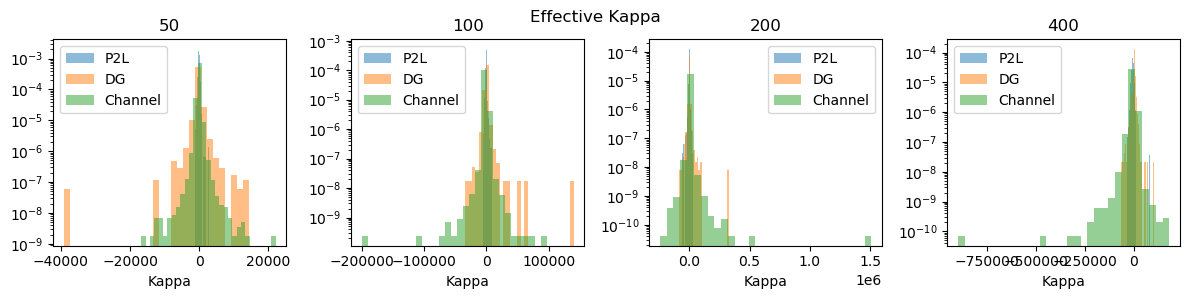

In [47]:
plt.figure(figsize=(12, 3))

for i, L in enumerate(['50', '100', '200', '400']):
    plt.subplot(1,4,1+i)
    (MOM6_P2L_data.datatree[L]['Kappa']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='P2L', density=True)
    (MOM6_DG_data.datatree[L]['Kappa']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='DG', density=True)
    (MITgcm_data.datatree[L]['Kappa']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='Channel', density=True)
    plt.legend()
    plt.yscale('log')
    plt.title(L)

plt.tight_layout()
plt.suptitle('Effective Kappa')

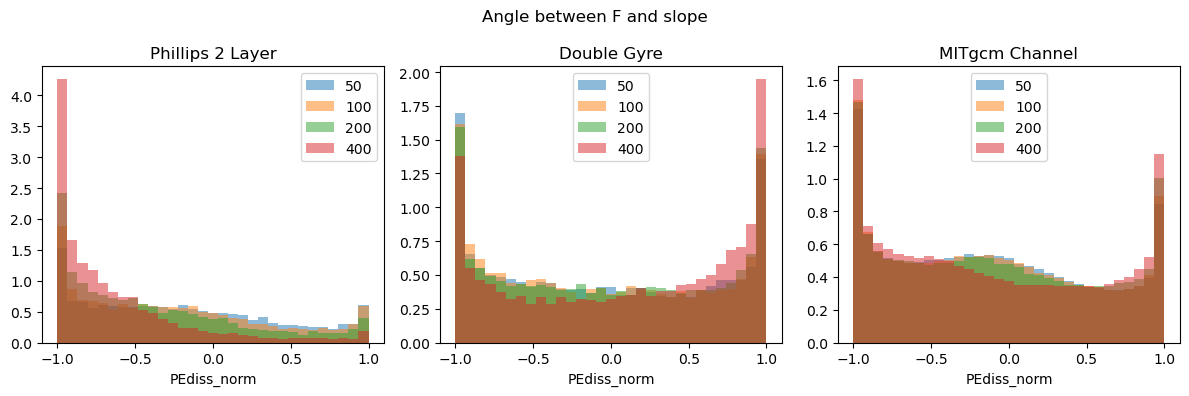

In [48]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    (MOM6_P2L_data.datatree[L]['PEdiss_norm']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
#plt.xlim([-5, -2])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    (MOM6_DG_data.datatree[L]['PEdiss_norm']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
#plt.xlim([-5, -2])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    (MITgcm_data.datatree[L]['PEdiss_norm']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
#plt.xlim([-5, -2])

plt.suptitle('Angle between F and slope')
plt.tight_layout()



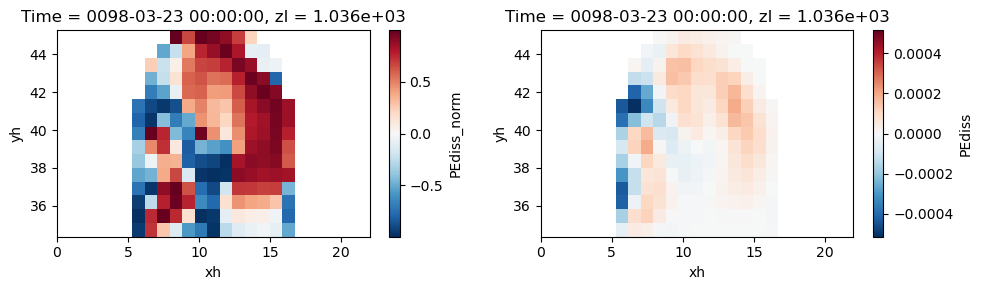

In [55]:
plt.figure(figsize=(10, 3))
L='400'
plt.subplot(121)
MOM6_DG_data.datatree[L]['PEdiss_norm'].isel(Time=0).plot()

plt.subplot(122)
MOM6_DG_data.datatree[L]['PEdiss'].isel(Time=0).plot()

plt.tight_layout()

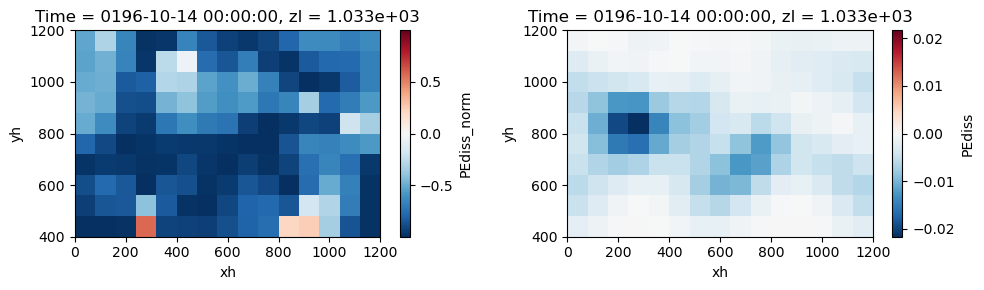

In [56]:
plt.figure(figsize=(10, 3))
L='400'
plt.subplot(121)
MOM6_P2L_data.datatree[L]['PEdiss_norm'].isel(Time=0).plot()

plt.subplot(122)
MOM6_P2L_data.datatree[L]['PEdiss'].isel(Time=0).plot()

plt.tight_layout()

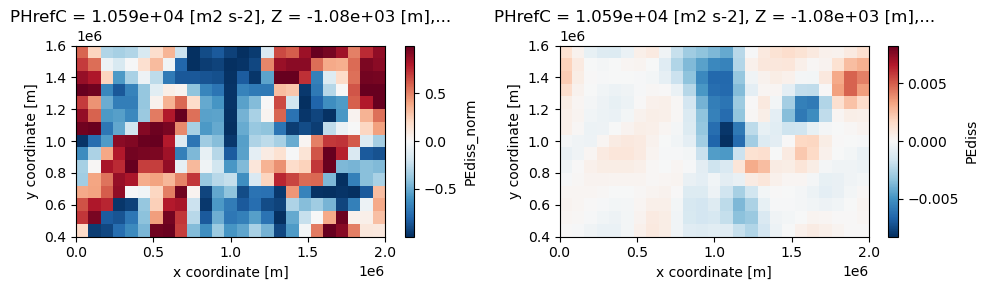

In [57]:
plt.figure(figsize=(10, 3))
L='400'
plt.subplot(121)
MITgcm_data.datatree[L]['PEdiss_norm'].isel(time=0, Z=10).plot()

plt.subplot(122)
MITgcm_data.datatree[L]['PEdiss'].isel(time=0, Z=10).plot()

plt.tight_layout()

Interesting to note that while the distributions of PE dissipation by eddies skews negative, the normalized version of this does not necessarily. Basically it is not the case that there are necessarily more events of downgradient thickness flux, but rather that the events of downgradient thickness flux that are taking place are often quite strong.

### Some maps

In [11]:
MOM6_DG_data.dataset

<xarray.Dataset>
Dimensions:    (Time: 3600, zl: 2, yh: 27, xh: 25, zi: 3)
Coordinates:
  * Time       (Time) object 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
  * xh         (xh) float64 0.44 1.32 2.2 3.08 3.96 ... 18.92 19.8 20.68 21.56
  * yh         (yh) float64 30.36 31.09 31.82 32.55 ... 47.09 47.82 48.55 49.27
  * zi         (zi) float64 1.034e+03 1.036e+03 1.037e+03
  * zl         (zl) float64 1.035e+03 1.036e+03
Data variables: (12/26)
    dudx       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    dudy       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    dvdx       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    dvdy       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    e          (Time, zi, yh, xh) float32 dask.array<chunksize=(36, 3, 27, 25), meta=np.ndarray>
    h          (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    ...         ...
    vh         (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vh_bar     (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vh_sg      (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vv         (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vv_bar     (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vv_sg      (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>

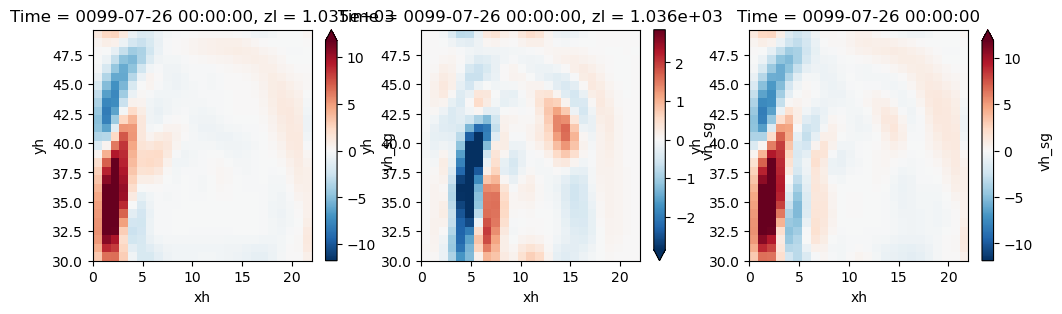

In [17]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=0).plot( robust=True)

plt.subplot(132)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=1).plot( robust=True)

plt.subplot(133)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1).sum('zl').plot( robust=True)

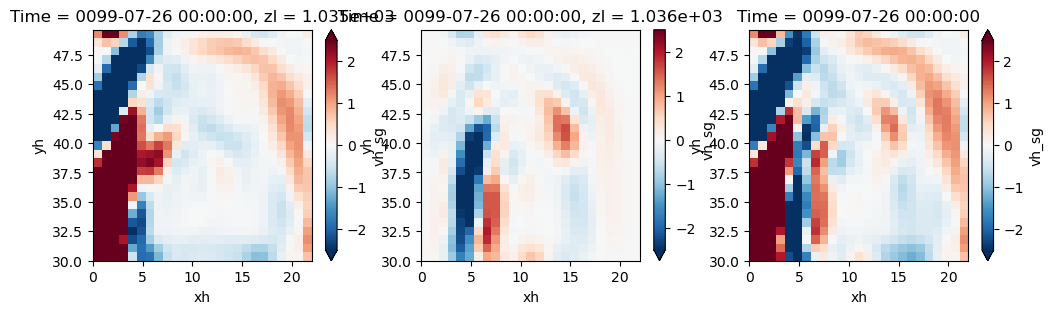

In [18]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=0).plot( vmin=-2.5)

plt.subplot(132)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=1).plot( vmin=-2.5)

plt.subplot(133)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1).sum('zl').plot( vmin=-2.5)

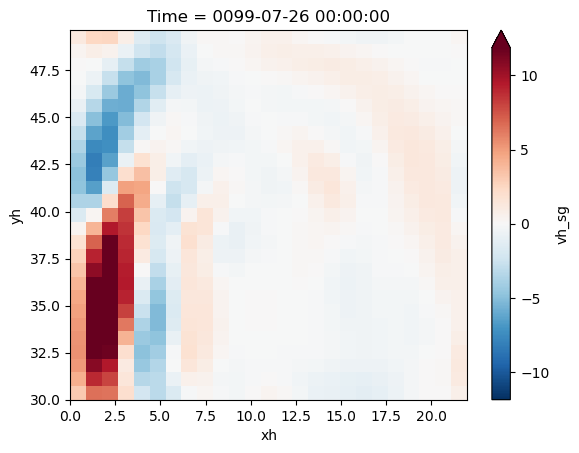

In [16]:
MOM6_DG_data.dataset.vh_sg.isel(Time=-1).plot( robust=True)

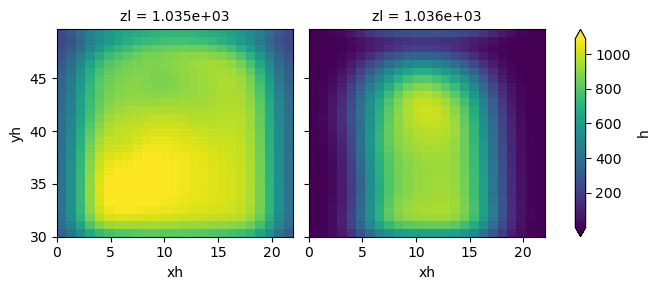

In [15]:
MOM6_DG_data.dataset.h.isel(Time=-1).plot(col='zl', robust=True)